In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin

In [53]:
class MixedCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=5):
        self.threshold = threshold
        self.one_hot_cols = []
        self.target_encoding_maps = {}

    def fit(self, X, y):
        self.target = y.name if hasattr(y, 'name') else 'target'
        for col in X.select_dtypes(include='object').columns:
            if X[col].nunique() < self.threshold:
                self.one_hot_cols.append(col)
            else:
                self.target_encoding_maps[col] = X[[col]].join(y).groupby(col)[self.target].mean().to_dict()
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.one_hot_cols:
            dummies = pd.get_dummies(X_new[col], prefix=col, drop_first=True, dtype=int)
            X_new = X_new.drop(col, axis=1)
            X_new = pd.concat([X_new, dummies], axis=1)

        for col, mapping in self.target_encoding_maps.items():
            X_new[col] = X_new[col].map(mapping).fillna(0)

        return X_new

Загружаем датасет

In [33]:
df = pd.read_excel('O:\Планирование\Папки сотрудников\Колчак\Bi\Данные для ВКР.xlsx')

Выведем первые 5 строк датасета

In [7]:
df.head()

,Модель,Товарная категория,Товарная группа,Целевая группа,Ассортимент,Кол-во размеров,Себестоимость,Цена розничная,Лидерство,Производство обобщенное,IMU,атрибут1,атрибут2,атрибут3,атрибут4,атрибут5,Страна оригинала,Страна производства,Тип ткани,Цвет,Однотонность,Элементы дизайна,Посадка,Модность,Перенос,Тип продукта,Коллекция,Атрибут цены,Полугодие,Квартал,Год,НЕДЕЛЯ PMM,МЕСЯЦ PMM,Заказ,Глубина на модель,коэффициент успешности модели,признак успешности модели
0,BAC002021 зеленый,ACT pants,ACT,B Kids,Основной ассортимент,6,144,499,Лидер,import,0.682565,comfort,NaN,NaN,240 gsm,print,USA,Бангладеш,Terry-fleece,Green,Solid,print,comfort,Commercial,NaN,Jogger,BTS,Medium,2 half 2016,3 quarter,2016,29,July,5000,2.465400,39,да
1,BAC002044 черный/синий,ACT pants,ACT,B Kids,Основной ассортимент,6,135,499,Лидер,import,0.702405,comfort,NaN,NaN,200 gsm,print,USA,Китай,Terry-fleece,Navy,Solid,print,comfort,Commercial,NaN,Jogger,BTS,Medium,2 half 2016,3 quarter,2016,29,July,10000,3.074141,77,да
2,BAC002044 красный,ACT pants,ACT,B Kids,Основной ассортимент,6,135,499,Лидер,import,0.702405,comfort,NaN,NaN,200 gsm,print,USA,Китай,Terry-fleece,Red,Solid,print,comfort,Commercial,NaN,Jogger,BTS,Medium,2 half 2016,3 quarter,2016,29,July,5000,2.567976,39,да
3,BAC002109 темно-синий,ACT pants,ACT,B Kids,Основной ассортимент,6,157,499,Лидер,import,0.653908,comfort,NaN,NaN,240 gsm,no elements,USA,Китай,Terry-fleece,Navy,Solid,no elements,comfort,Commercial,NaN,Jogger,BTS,Medium,2 half 2016,3 quarter,2016,32,August,10000,2.997602,186,да
4,BAC002109 серый меланж,ACT pants,ACT,B Kids,Основной ассортимент,6,202,499,Лидер,import,0.554709,comfort,NaN,NaN,240 gsm,no elements,USA,Китай,Terry-fleece,Grey Melange,Solid,no elements,comfort,Commercial,NaN,Jogger,BTS,Medium,2 half 2016,3 quarter,2016,32,August,10000,3.008424,133,да


Проверим количество пустых значений

In [38]:
df.isna().sum()

Модель                               0
Товарная категория                   0
Товарная группа                      0
Целевая группа                       0
Ассортимент                          0
Кол-во размеров                      0
Себестоимость                        0
Цена розничная                       0
Лидерство                            0
Производство обобщенное              0
IMU                                  0
атрибут1                           788
атрибут2                          4433
атрибут3                         10153
атрибут4                          4410
атрибут5                         14236
Страна оригинала                  2679
Страна производства                  8
Тип ткани                         2205
Цвет                                72
Однотонность                      8018
Элементы дизайна                  3642
Посадка                           8806
Модность                          1893
Перенос                          13538
Тип продукта             

Посчитаем долю пустых значений по столбцамю: во всем датасете и по годам

In [39]:
# Общая проверка пропущенных значений
total_rows = len(df)
null_counts = df.isnull().sum()
null_share = null_counts / total_rows      # доля
 
# Объединённый результат
null_report = pd.DataFrame({
    'null_count': null_counts,
    'null_share': null_share
})
 
# Сортировка по убыванию доли null (необязательно)
null_report = null_report[null_report['null_count'] > 0]  # сортируем значения больше 0
null_report = null_report.sort_values(by='null_share', ascending=False)
 
print(null_report)

                     null_count  null_share
атрибут5                  14236    0.189773
Перенос                   13538    0.180468
атрибут3                  10153    0.135344
Посадка                    8806    0.117388
Однотонность               8018    0.106884
Тип продукта               5018    0.066892
атрибут2                   4433    0.059094
атрибут4                   4410    0.058787
Элементы дизайна           3642    0.048550
Страна оригинала           2679    0.035712
Тип ткани                  2205    0.029394
Модность                   1893    0.025235
атрибут1                    788    0.010504
Атрибут цены                342    0.004559
Цвет                         72    0.000960
Страна производства           8    0.000107


In [40]:
# Показывать все строки
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Группировка по 'Год' и подсчёт null и долей
result = []
 
for year, group in df.groupby('Год'):
    total_rows = len(group)
    null_counts = group.isnull().sum()
    null_share = null_counts / total_rows
 
    report = pd.DataFrame({
        'year': year,
        'column': null_counts.index,
        'null_count': null_counts.values,
        'null_share': null_share.values
    })
 
    result.append(report)
 
# Объединяем по всем годам
final_report = pd.concat(result, ignore_index=True)
 
# Фильтруем по колонкам, где доля незаполненных полей более 15%
final_report = final_report[final_report['null_share'] > 0.15]
 
# Сортировка
final_report = final_report.sort_values(['year', 'null_share'], ascending=[True, False])
 

print(final_report)

     year            column  null_count  null_share
24   2016           Перенос        7694    0.909134
15   2016          атрибут5        2084    0.246248
13   2016          атрибут3        1324    0.156446
61   2017           Перенос        5793    0.550718
52   2017          атрибут5        2590    0.246221
53   2017  Страна оригинала        2246    0.213518
50   2017          атрибут3        1923    0.182812
89   2018          атрибут5        2749    0.289704
87   2018          атрибут3        1856    0.195595
126  2019          атрибут5        1859    0.237269
163  2020          атрибут5        1057    0.163774
200  2021          атрибут5        1280    0.167036


Удалим столбцы Атрибут 5, атрибут 3 и Перенос поскольку нам много пустых значений. Удалим поле Модель - оно уникально и поля полугодие и квартал, оставим только год и неделю

In [34]:
df = df.drop(['атрибут5','атрибут3','Перенос', 'Модель','Полугодие','Квартал'],axis=1)

В оставшихся категориальных признаках заменим 0 и пустоту на n/a

In [35]:
for col in df.describe(include = 'object'):
    df[col]=df[col].fillna('n/a')
    df[col]=df[col].replace('0','n/a')

Определим таргет

In [36]:
df.loc[(df['Лидерство'] == 'Выше плана') | (df['Лидерство'] == 'Лидер') | (df['Лидерство'] == 'Остальные'),'target'] = 1
df.loc[(df['Лидерство'] == 'Ниже плана') | (df['Лидерство'] == 'Анти-лидер'),'target'] = 0

Удалим поля, которые однозначно указывают на лидерство

In [37]:
df = df.drop(['признак успешности модели', 'Лидерство', 'коэффициент успешности модели' ],axis=1)

Проверим сбалансированность таргета

In [38]:
df['target'].value_counts()

target
0.0    43879
1.0    31137
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75016 entries, 0 to 75015
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Товарная категория       75016 non-null  object 
 1   Товарная группа          75016 non-null  object 
 2   Целевая группа           75016 non-null  object 
 3   Ассортимент              75016 non-null  object 
 4   Кол-во размеров          75016 non-null  int64  
 5   Себестоимость            75016 non-null  int64  
 6   Цена розничная           75016 non-null  int64  
 7   Производство обобщенное  75016 non-null  object 
 8   IMU                      75016 non-null  float64
 9   атрибут1                 75016 non-null  object 
 10  атрибут2                 75016 non-null  object 
 11  атрибут4                 75016 non-null  object 
 12  Страна оригинала         75016 non-null  object 
 13  Страна производства      75016 non-null  object 
 14  Тип ткани             

Проверим корреляцию между числовыми признаками

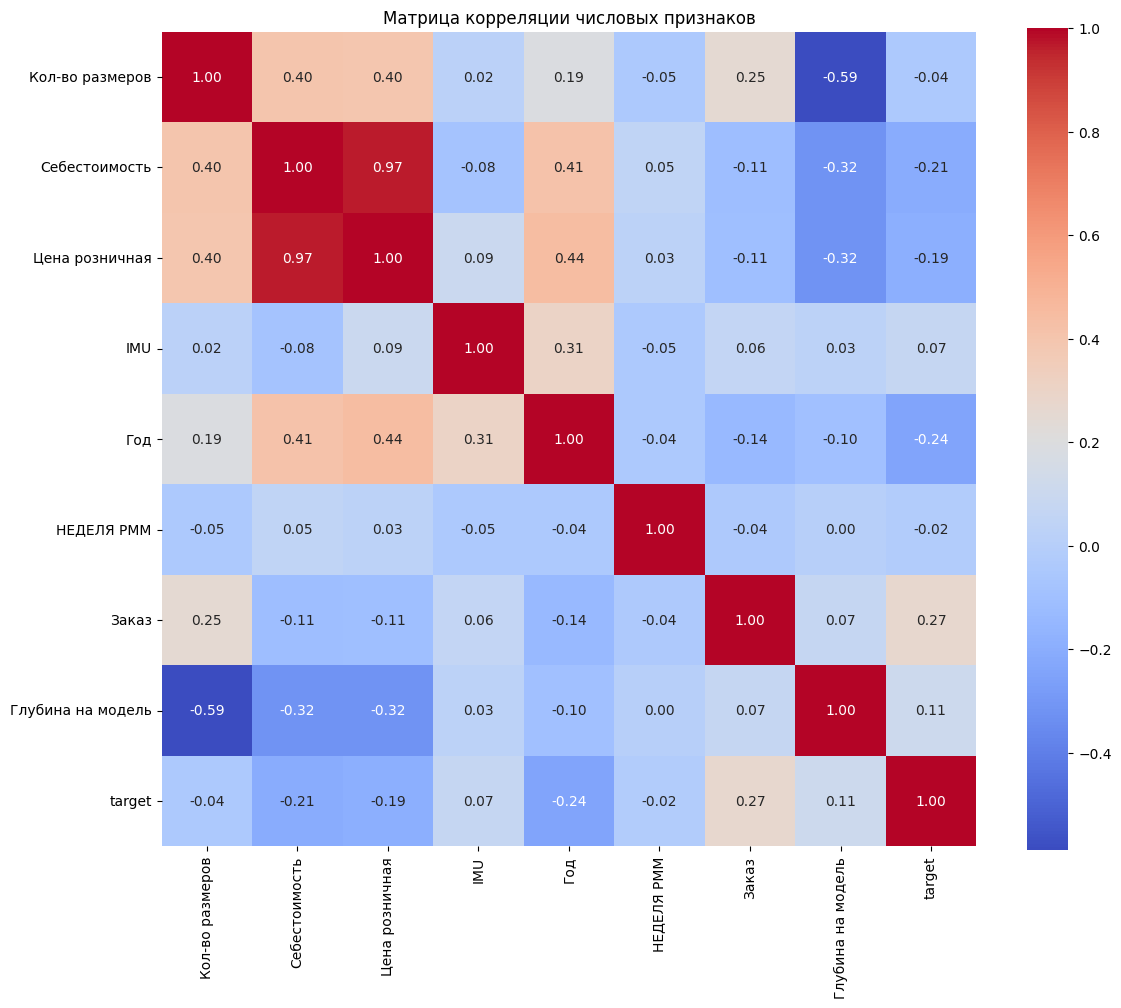

In [47]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Матрица корреляции числовых признаков")
plt.tight_layout()
plt.show()

Посмотрим гистограммы распределения

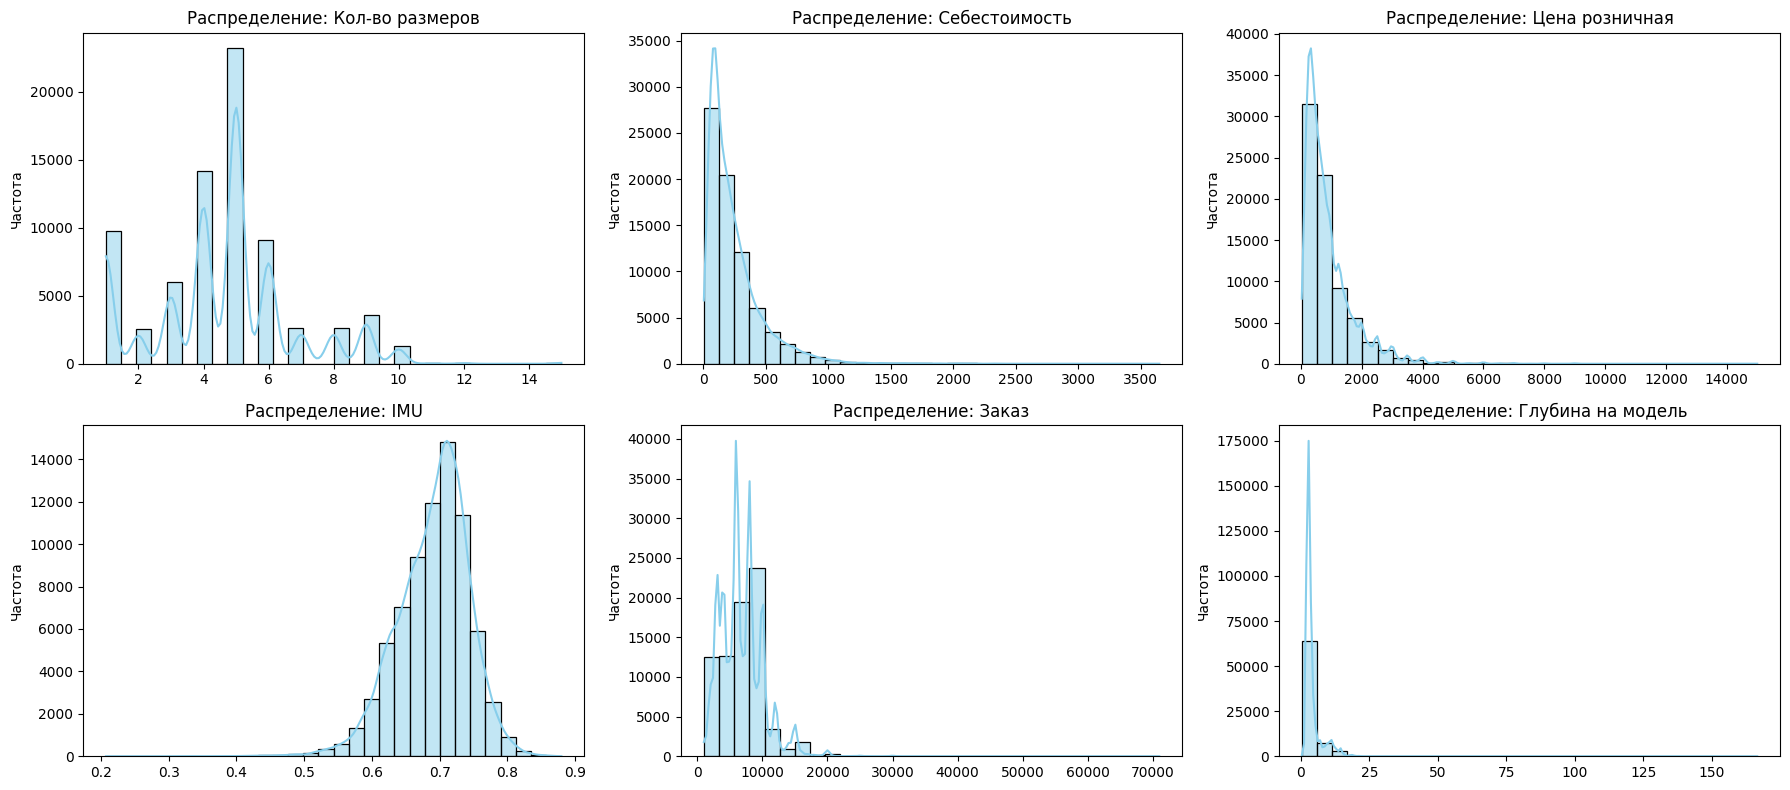

In [48]:
numeric_df = numeric_df.drop(['Год', 'НЕДЕЛЯ PMM', 'target' ],axis=1)

# Определим количество признаков
cols = numeric_df.columns
n = len(cols)
rows = (n + 2) // 3  # по 3 графика в строку

# Построение сетки графиков
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(data=numeric_df, x=col, kde=True, ax=axes[i], color='skyblue', bins=30)
    axes[i].set_title(f"Распределение: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Частота")

# Удалим лишние пустые графики
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Выделим и проанализируем категориальные признаки

In [49]:
df.describe(include = 'object')

,Товарная категория,Товарная группа,Целевая группа,Ассортимент,Производство обобщенное,атрибут1,атрибут2,атрибут4,Страна оригинала,Страна производства,Тип ткани,Цвет,Однотонность,Элементы дизайна,Посадка,Модность,Тип продукта,Коллекция,Атрибут цены,МЕСЯЦ PMM
count,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016,75016
unique,131,30,12,2,3,417,198,489,21,11,206,158,25,155,370,9,672,7,4,12
top,T-SHIRTS S-sl,KNIT TOPS,G13+ GJ,Основной ассортимент,import,Straight,Solid,No print,Internet,Китай,Jersey,Multicolor,Solid,no elements,standard,Commercial,graphic,BTS,Medium,July
freq,9312,13051,23087,46272,60239,7359,24279,9730,26408,33736,12134,12421,49227,35626,11044,52529,5453,32568,57309,11907


По строке unique сразу видно, что уникальность распределения значений внутри атрибутов часто превышает 100 и поэтому визуальный анализ затруднен. Выделим топ 50 категорий, а остальные объединим в Other и после выведем визуализацию распределения категорий

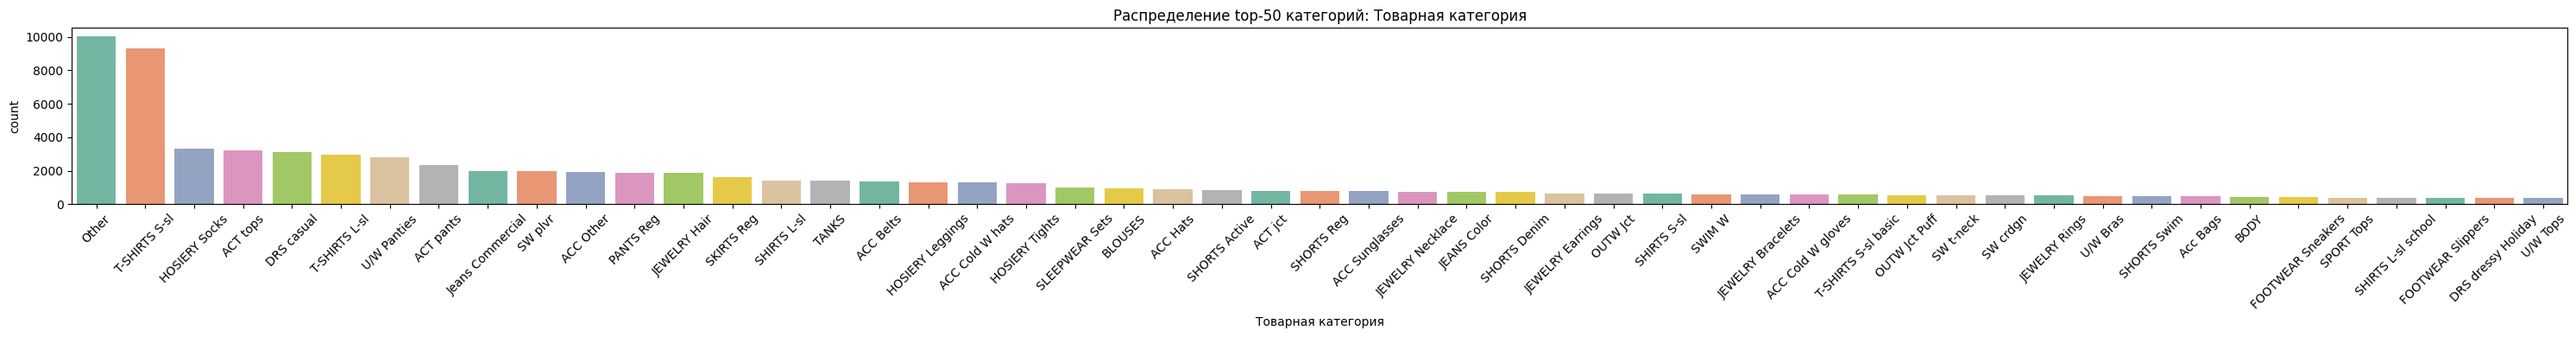

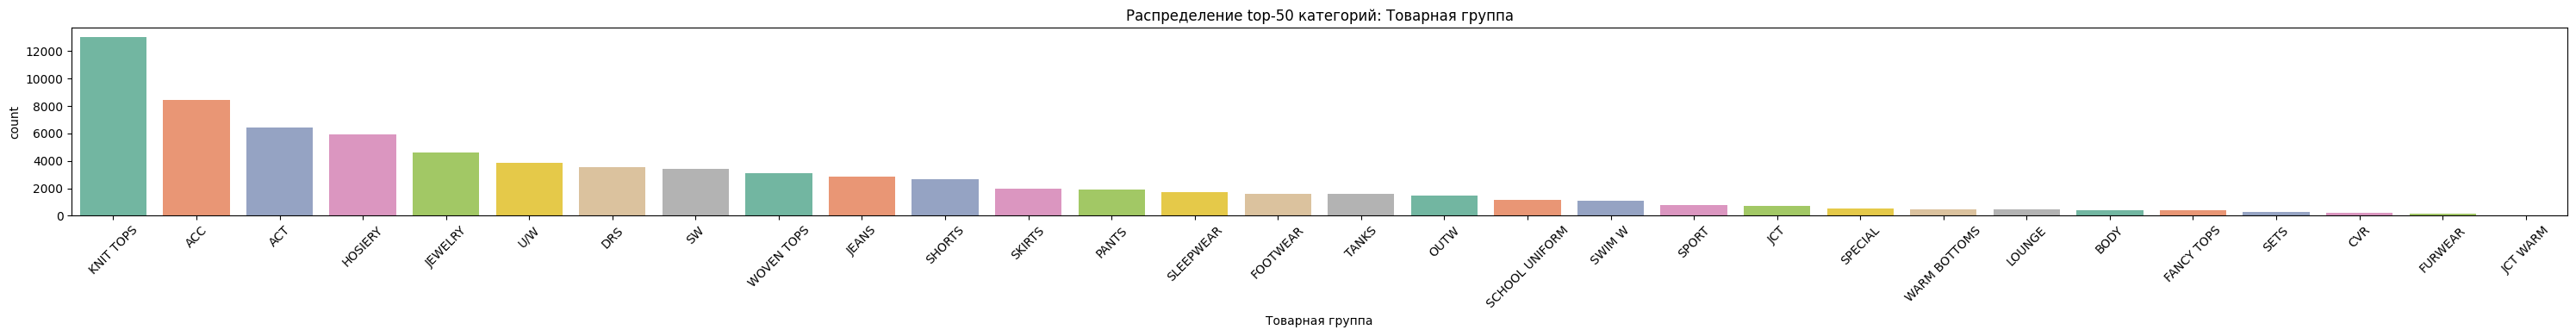

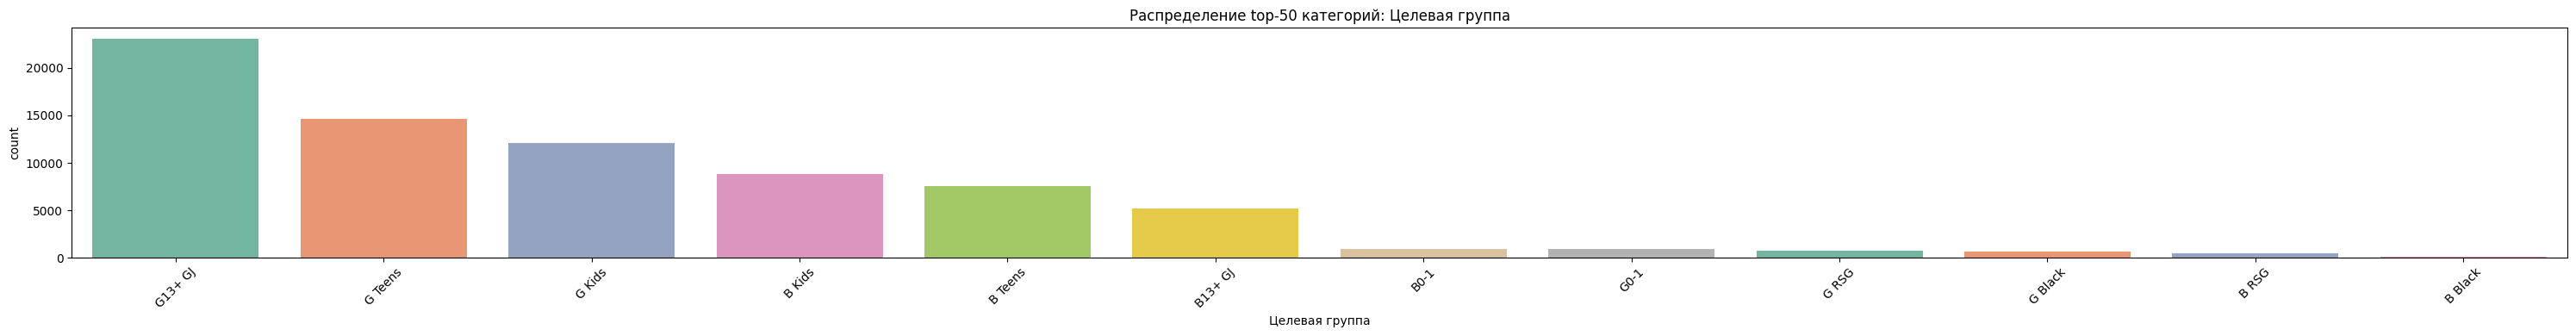

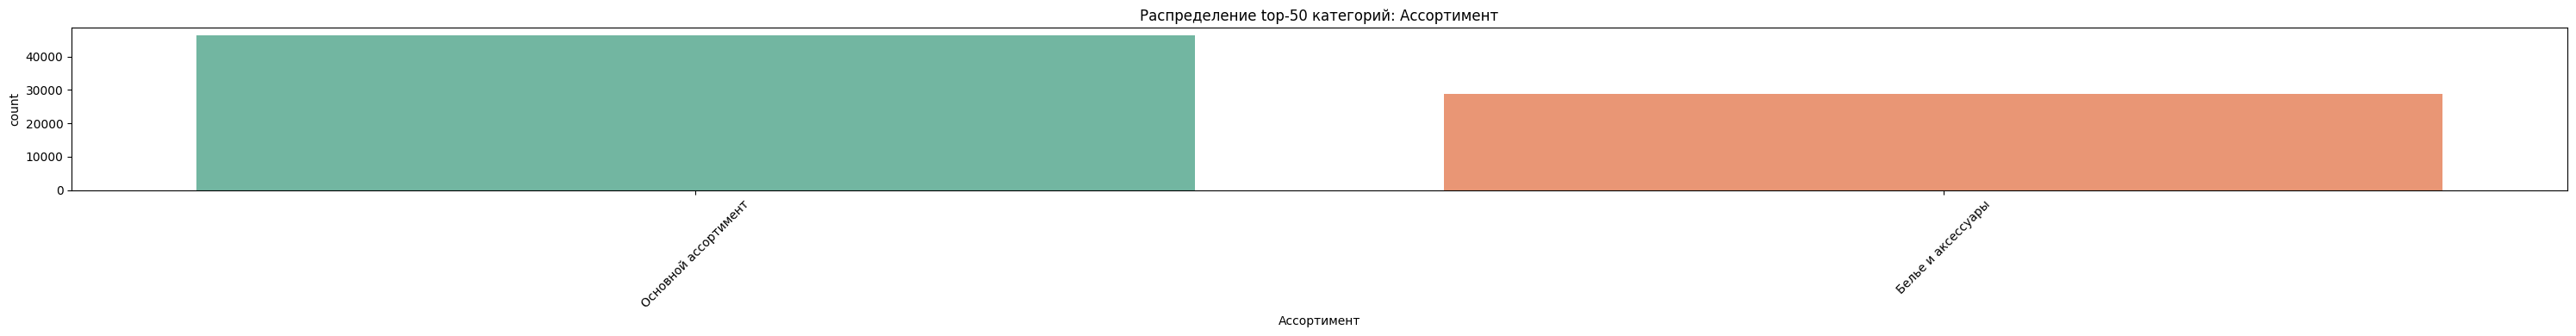

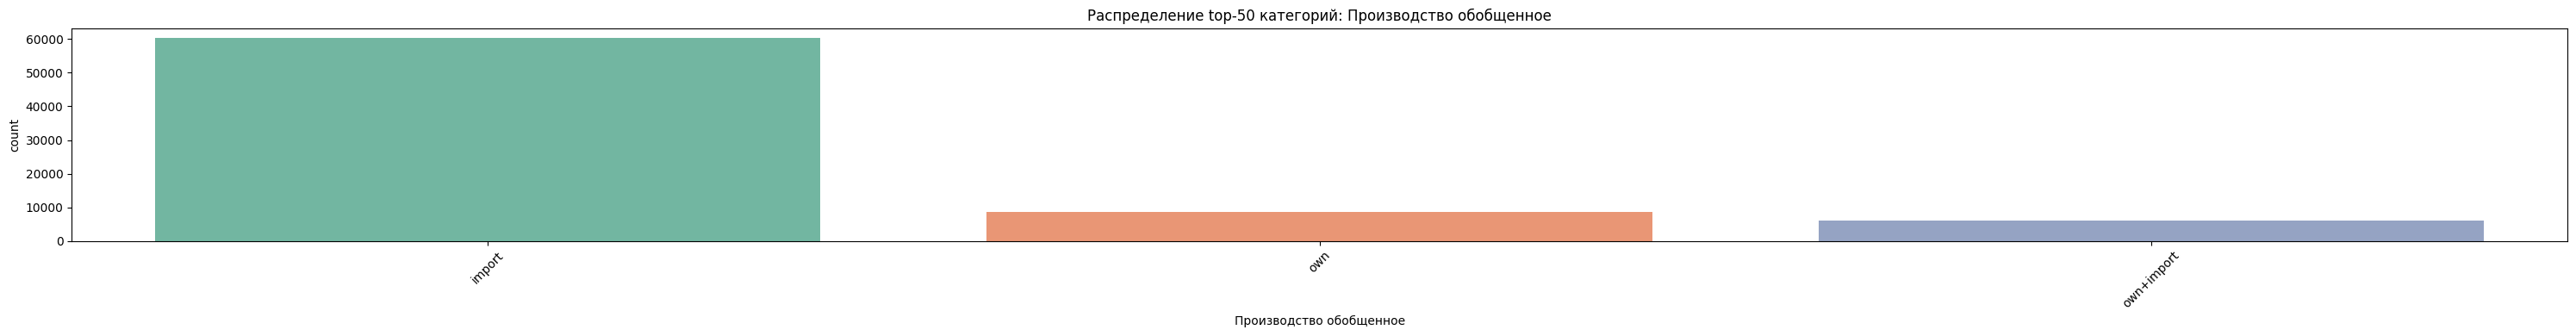

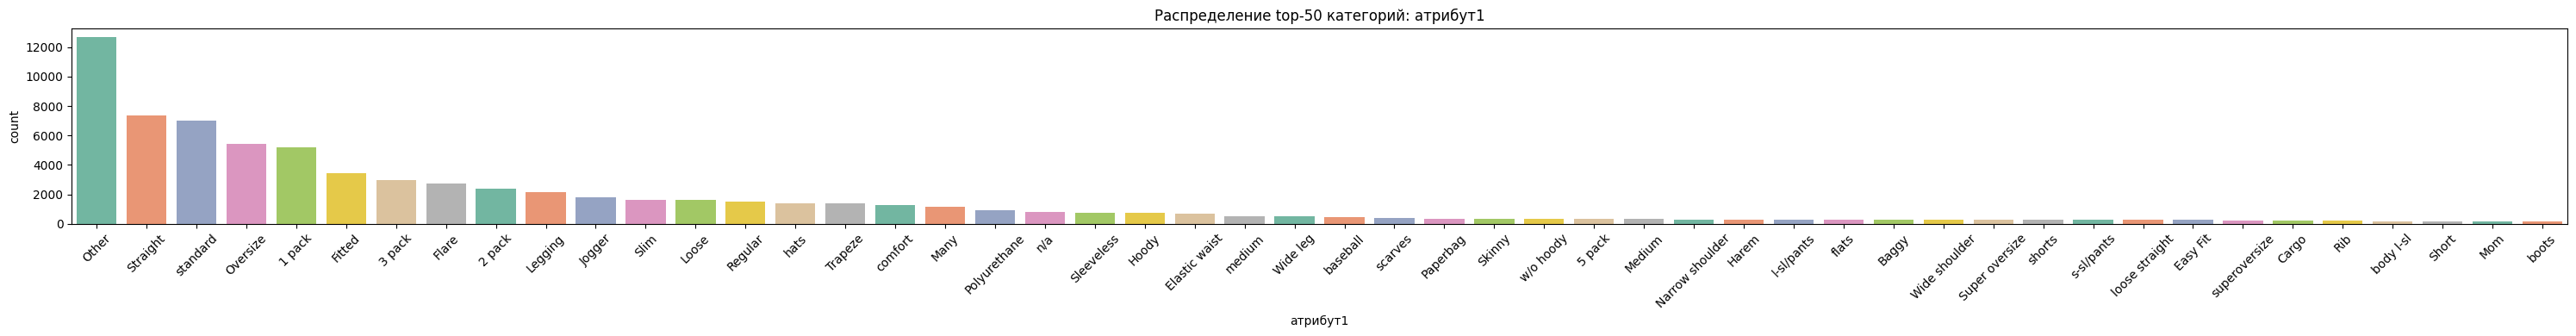

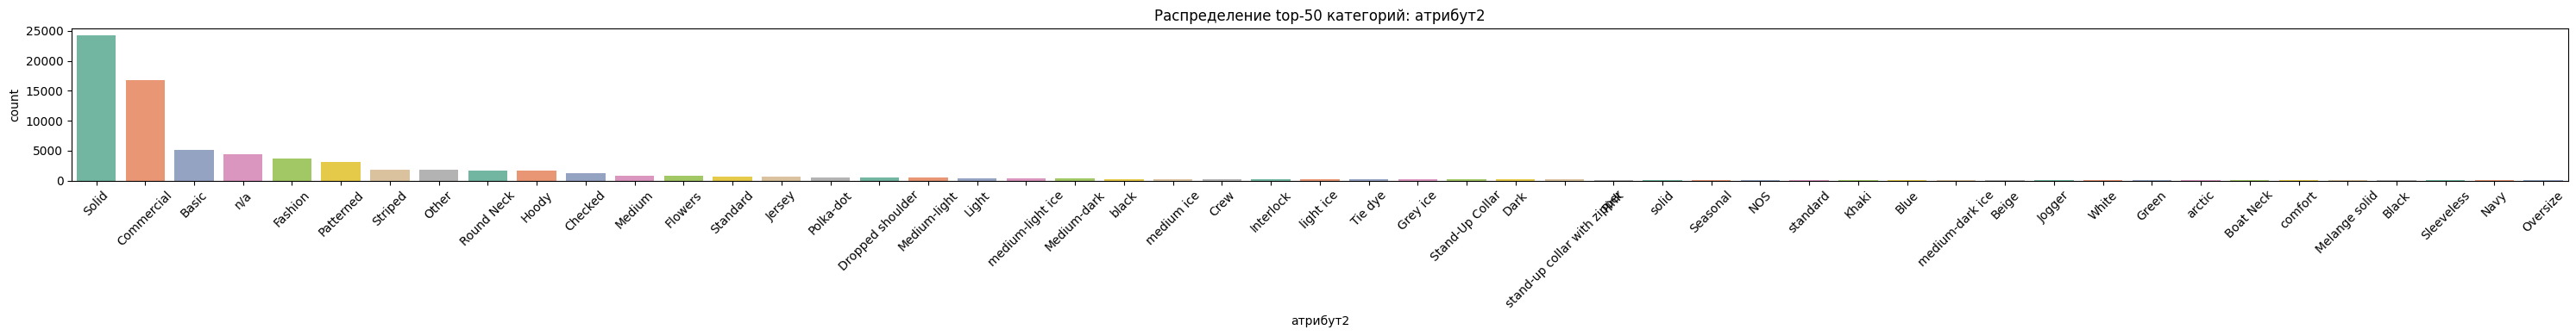

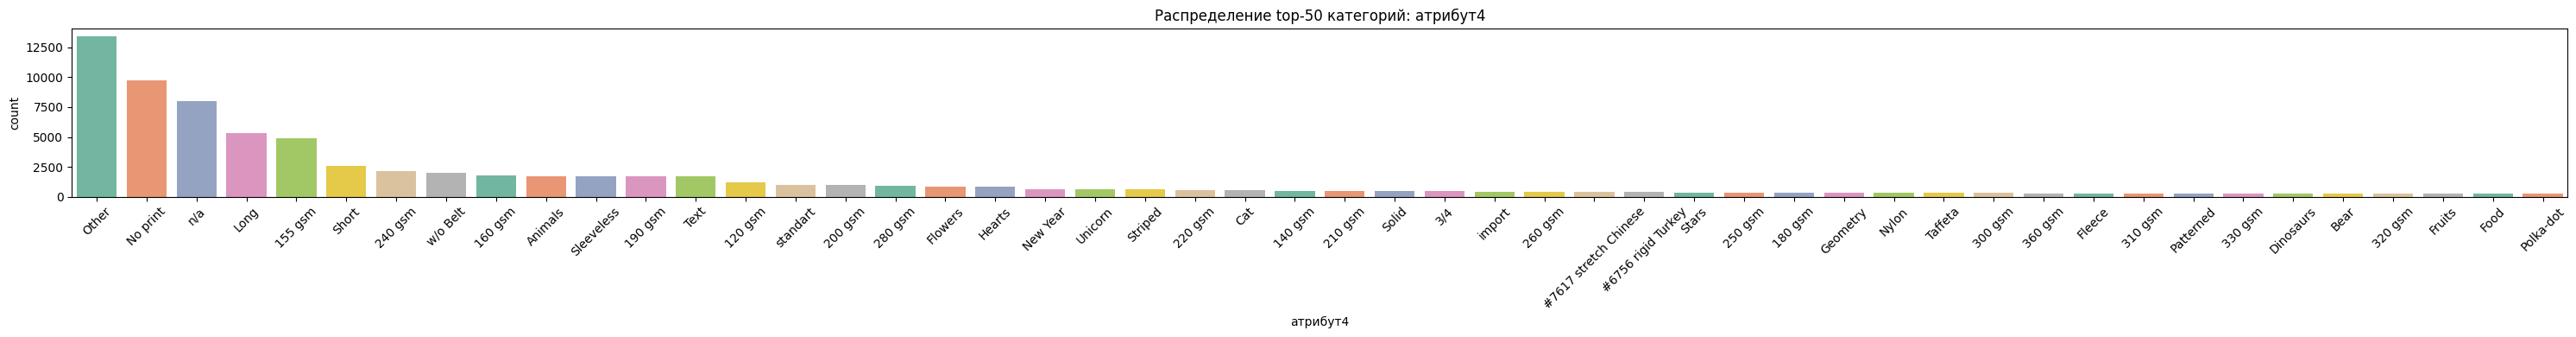

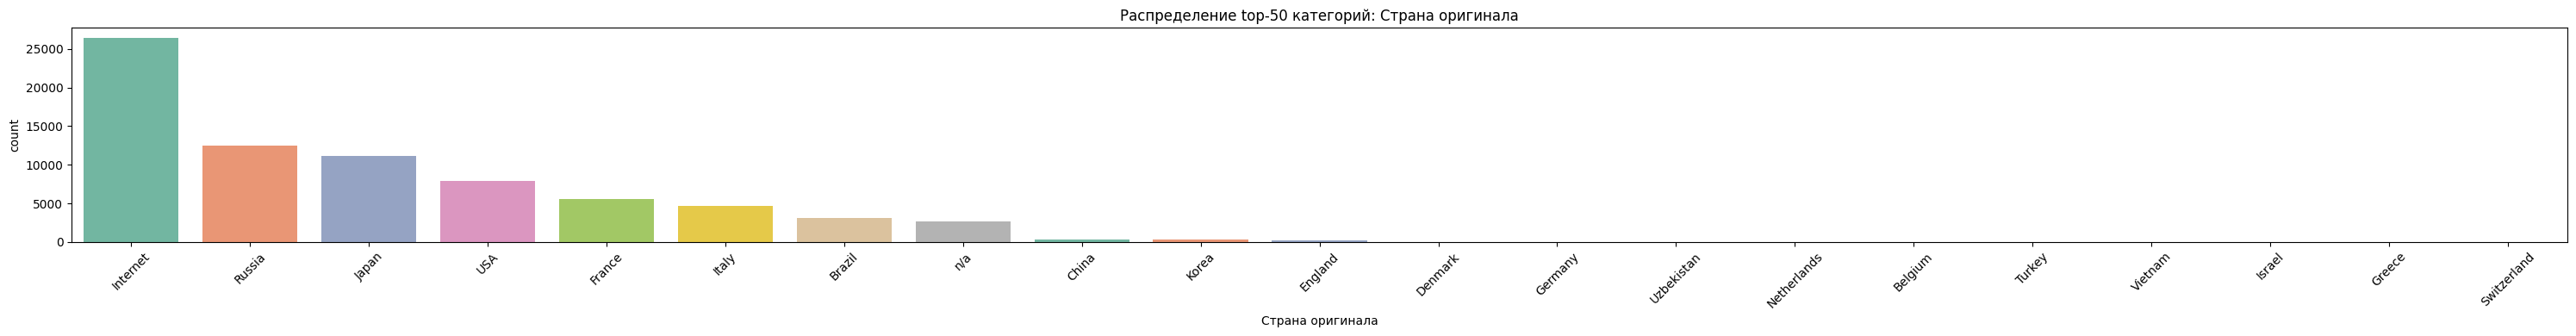

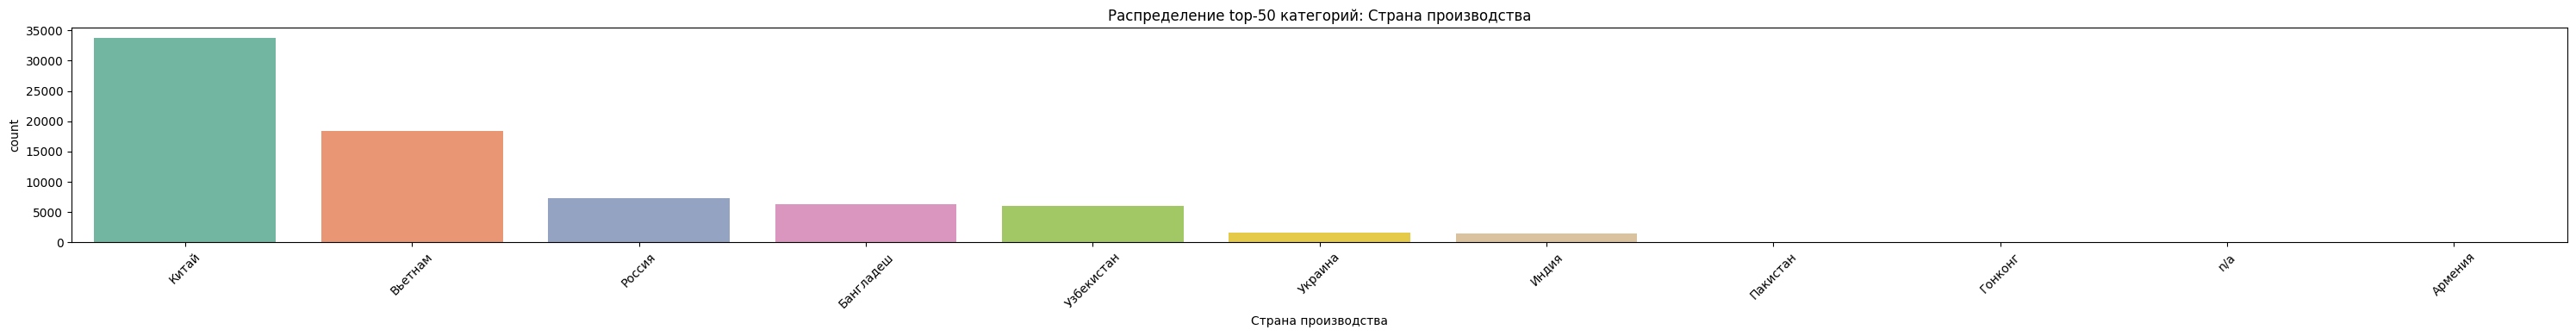

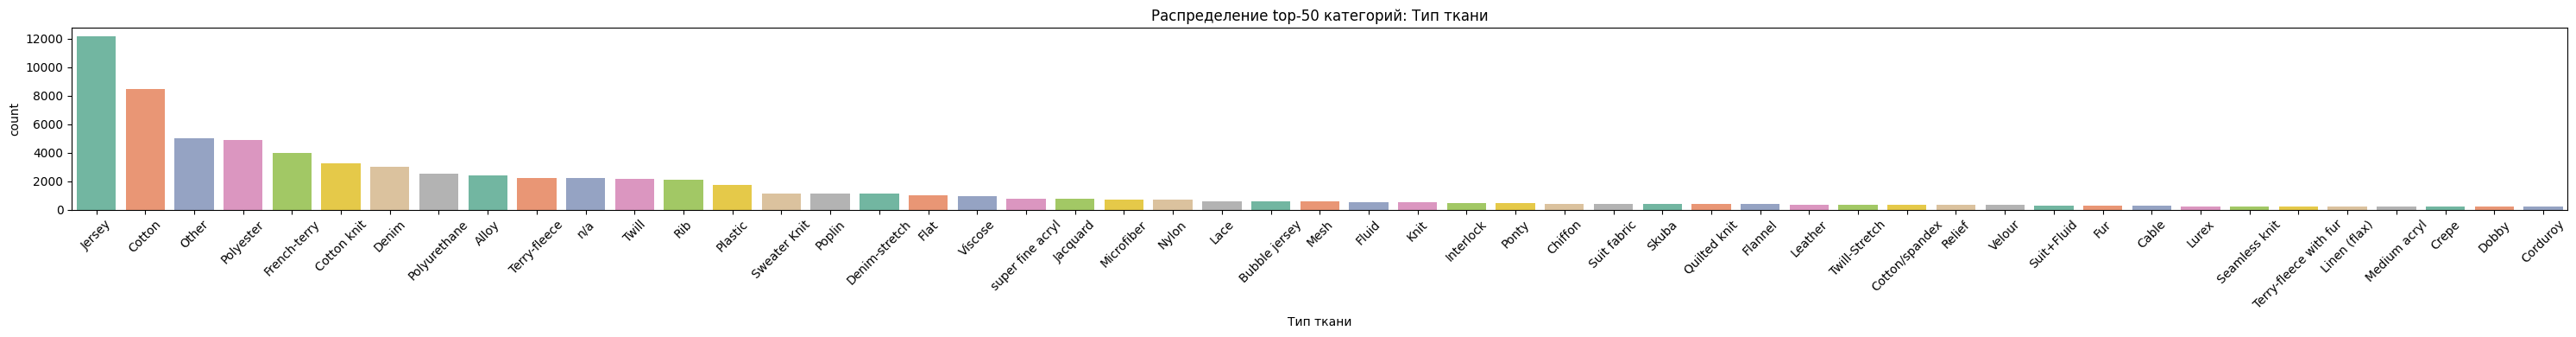

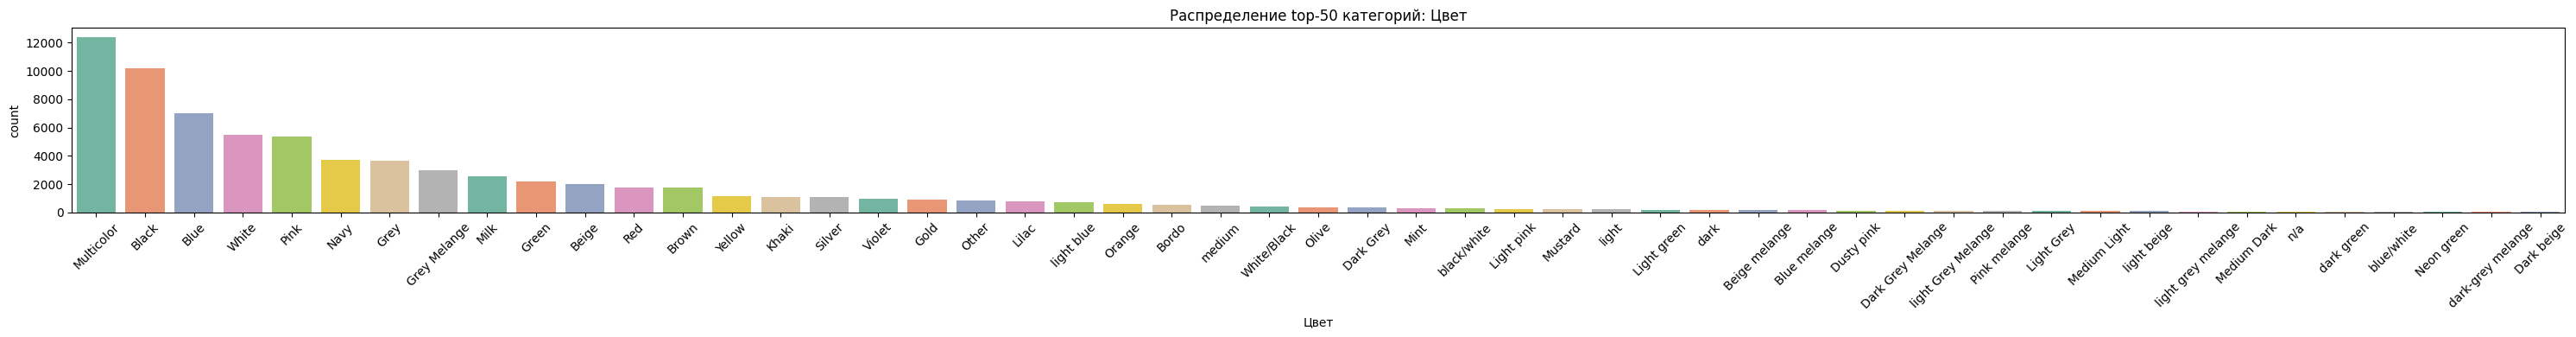

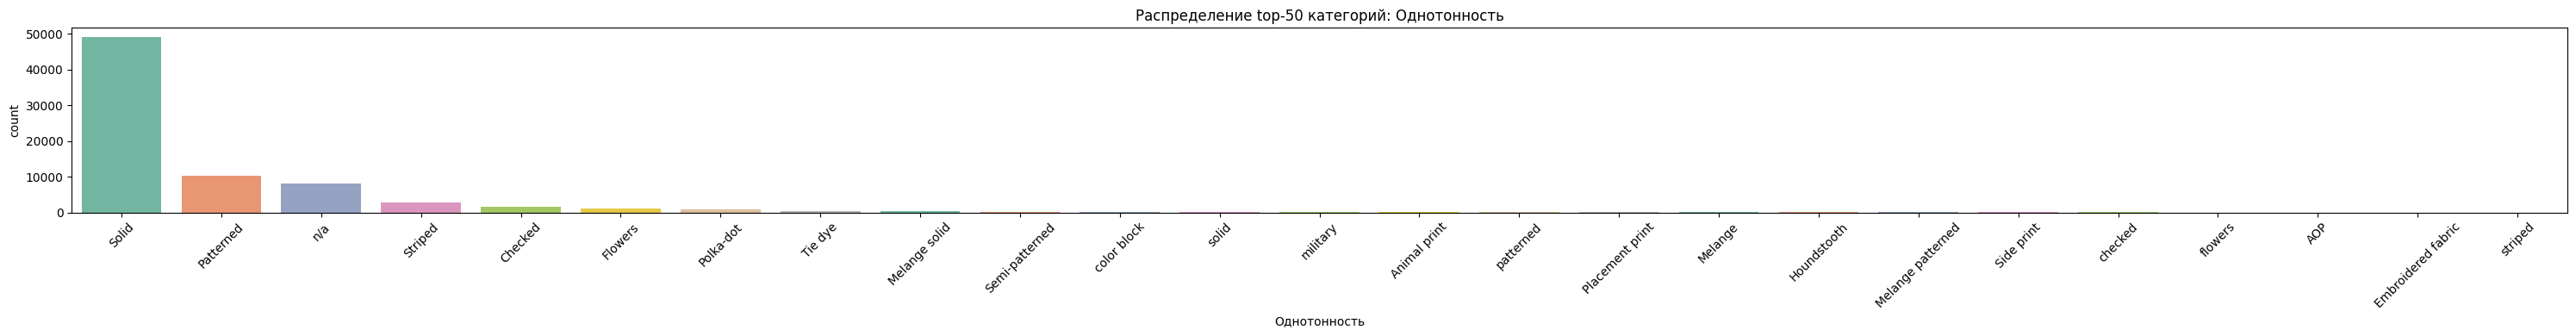

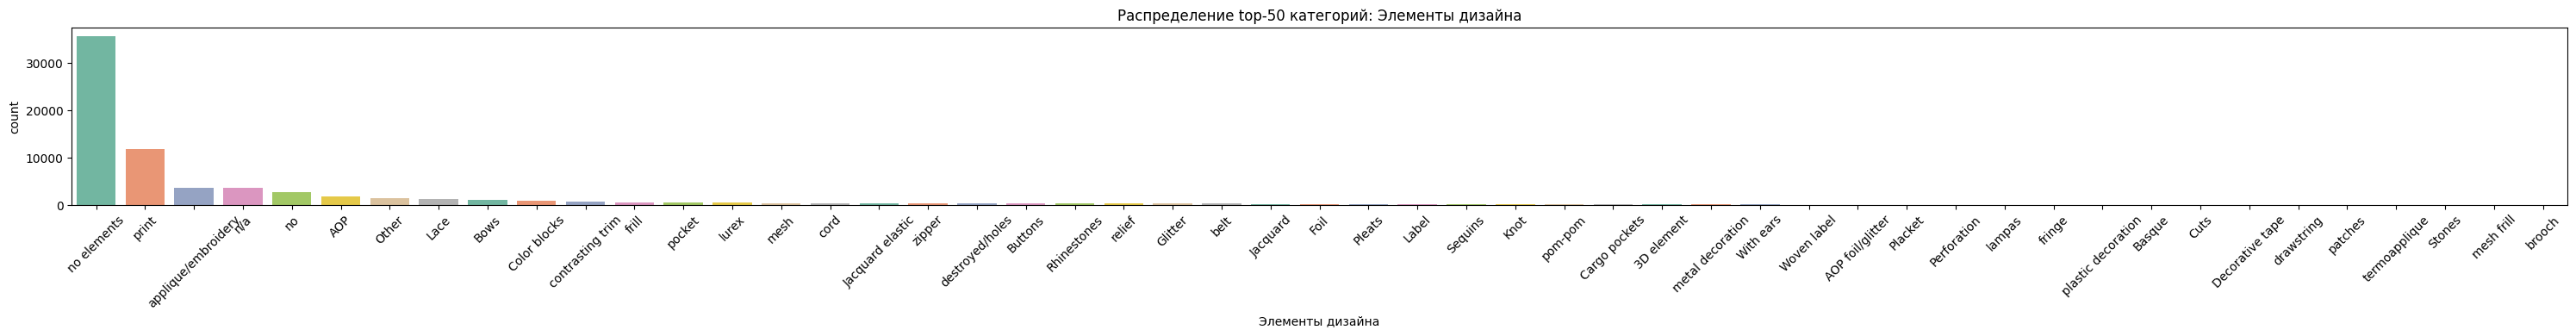

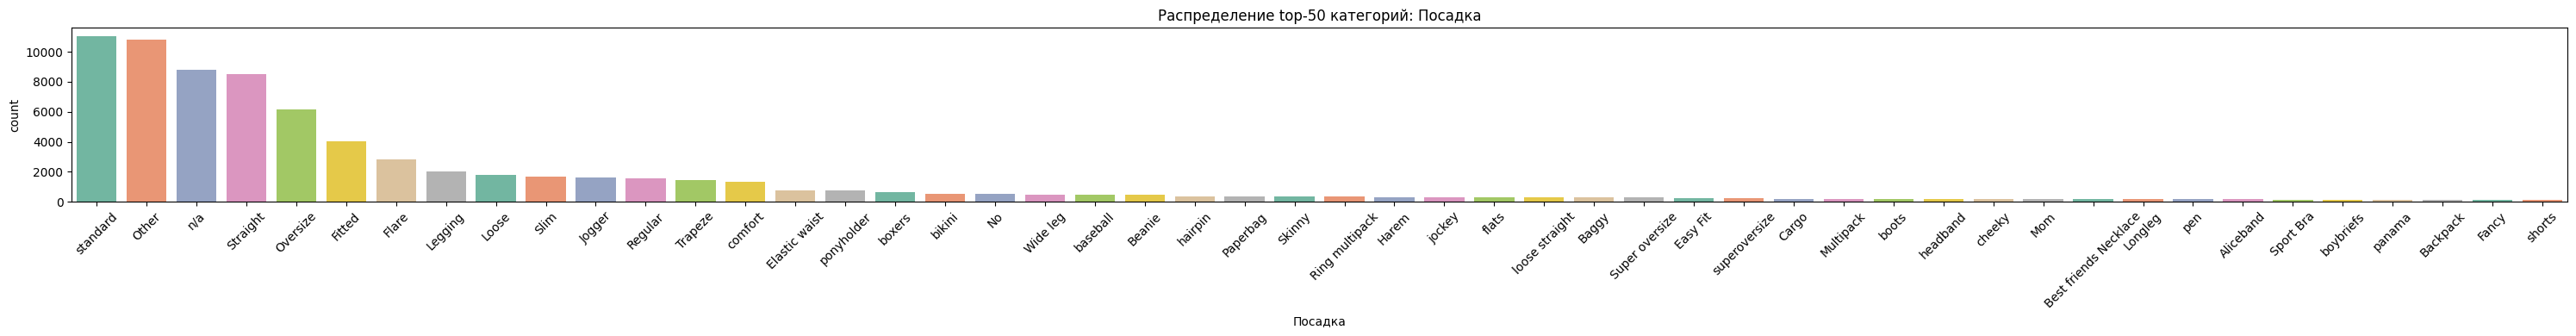

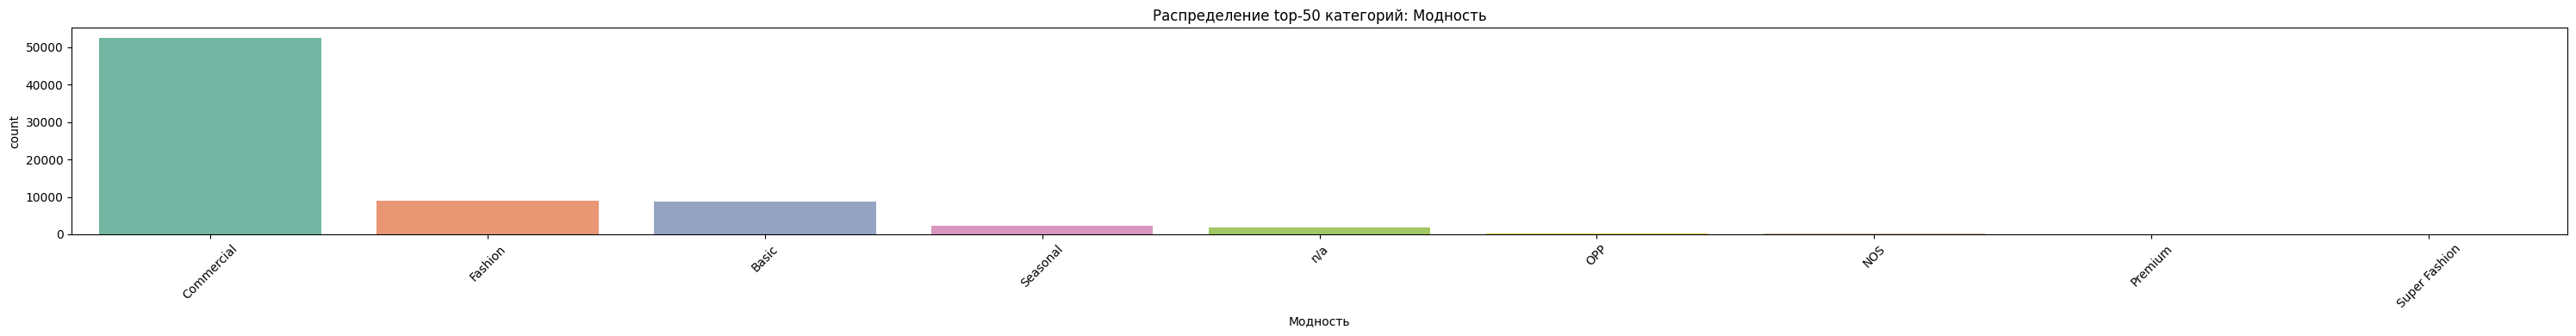

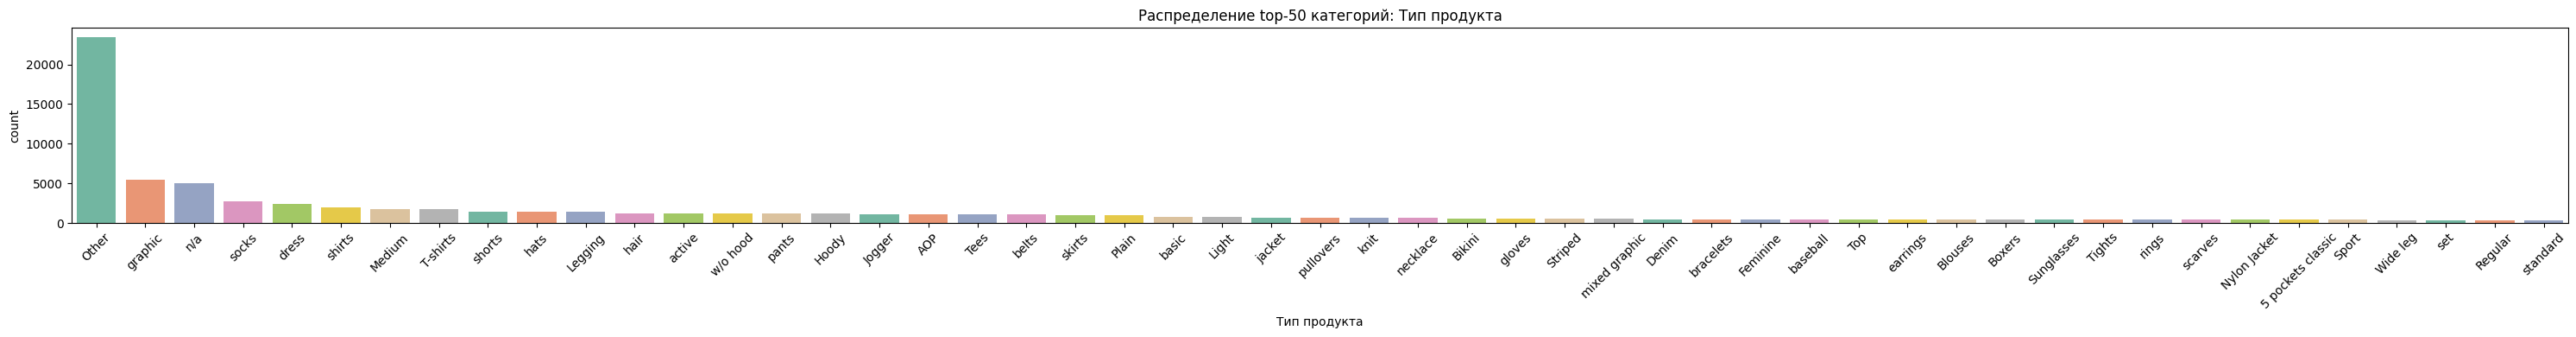

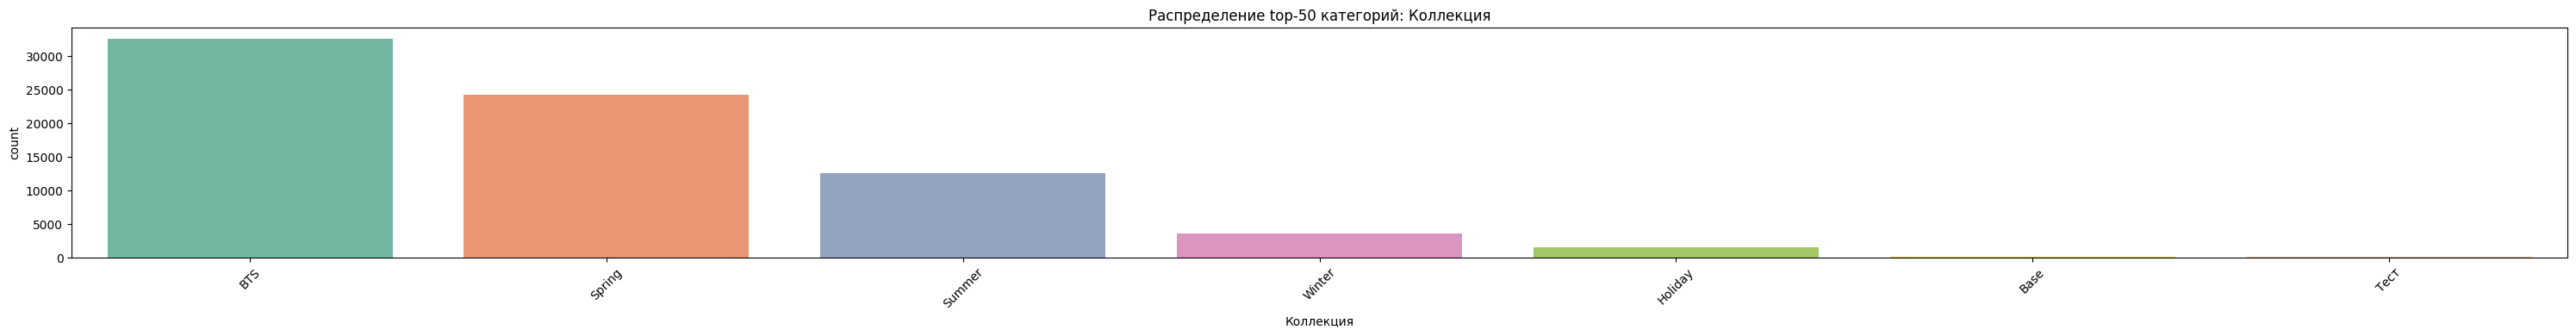

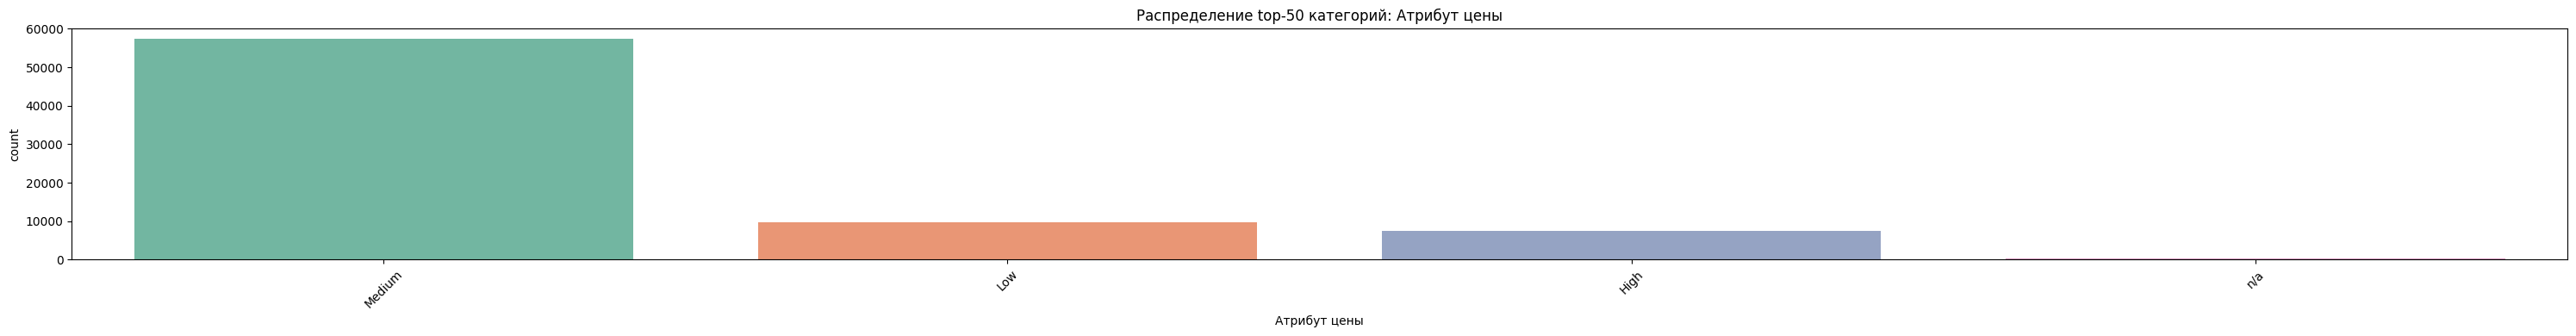

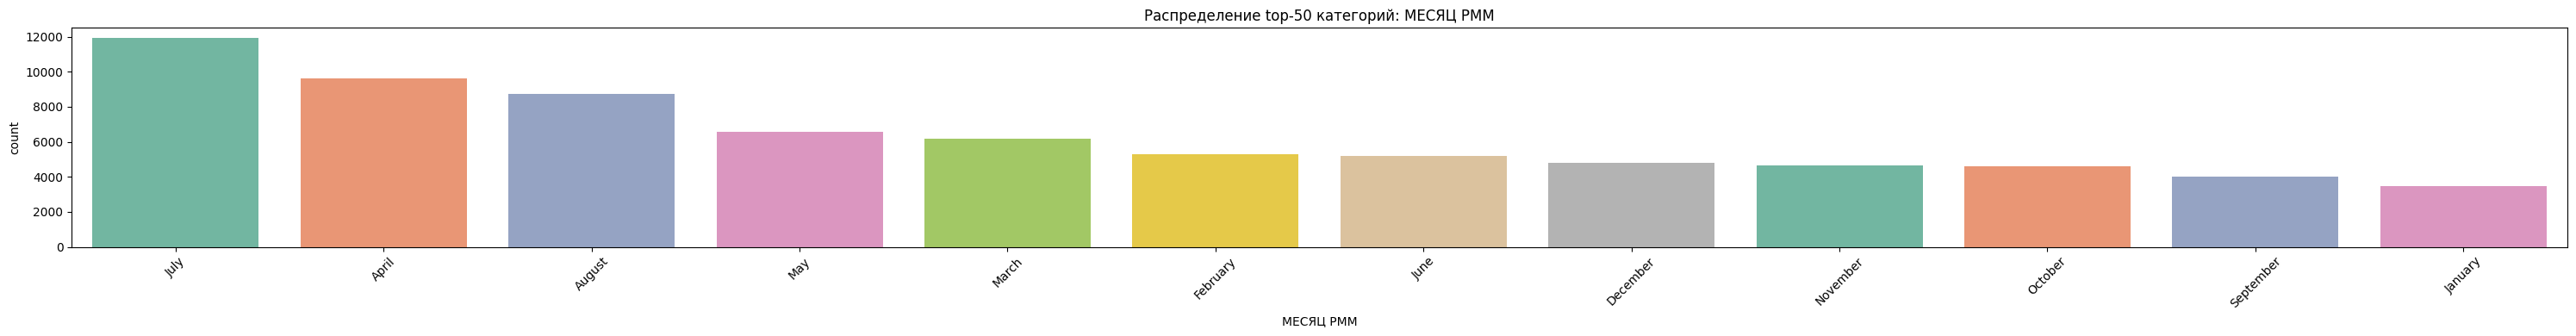

In [50]:
def keep_top_categories(df, col, top_n=50):
    top_categories = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df = keep_top_categories(df, col, top_n=50)
    
for col in categorical_cols:
    plt.figure(figsize=(30, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette='Set2')
    plt.title(f"Распределение top-50 категорий: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

Далее выделим топ атрибутов по силе влияния на таргет и выведем barplot для них

Топ-10 категориальных признаков по связи с target:
  Категориальный признак  Cramér's V
0     Товарная категория    0.217320
1        Товарная группа    0.214646
2               атрибут4    0.198211
3              Тип ткани    0.195814
4           Тип продукта    0.194269
5               атрибут1    0.188590
6       Страна оригинала    0.173828
7                Посадка    0.170549
8               атрибут2    0.165999
9                   Цвет    0.162429


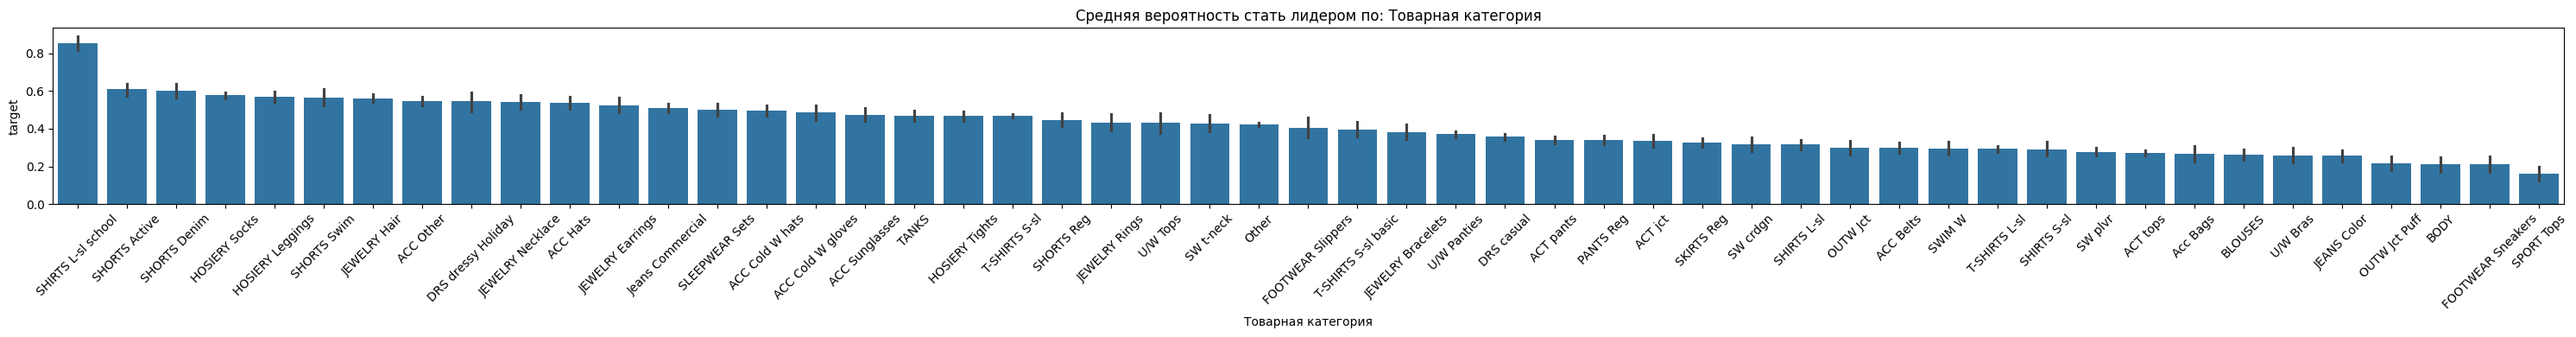

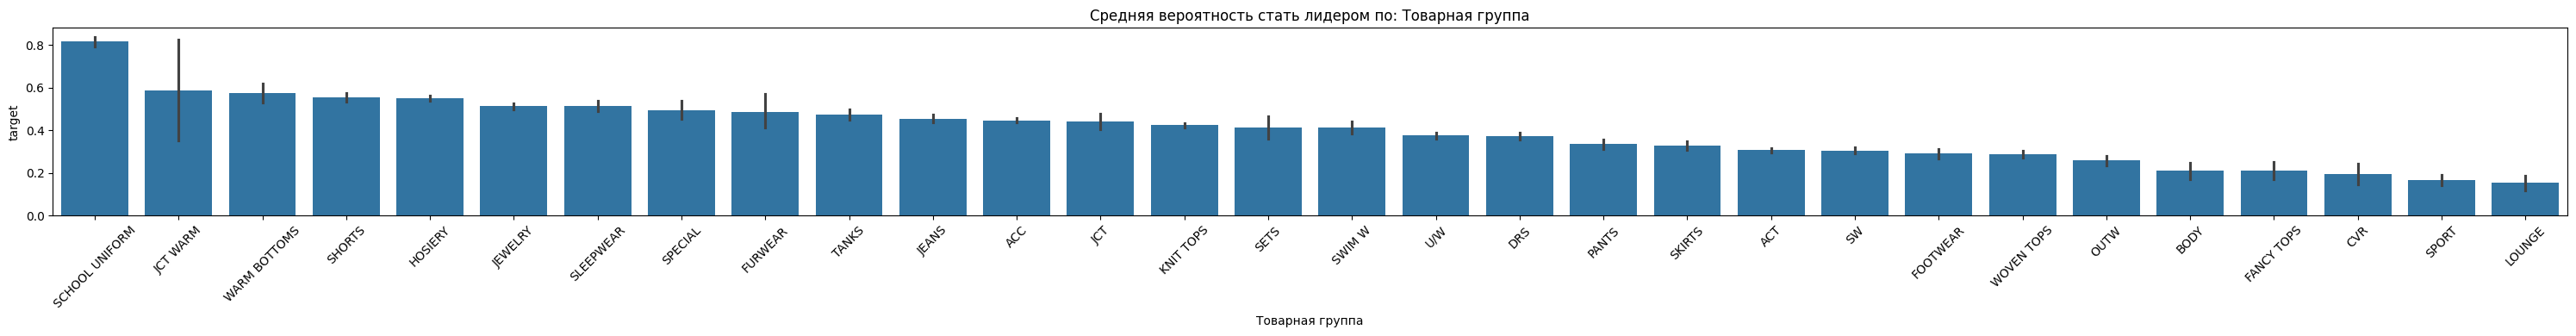

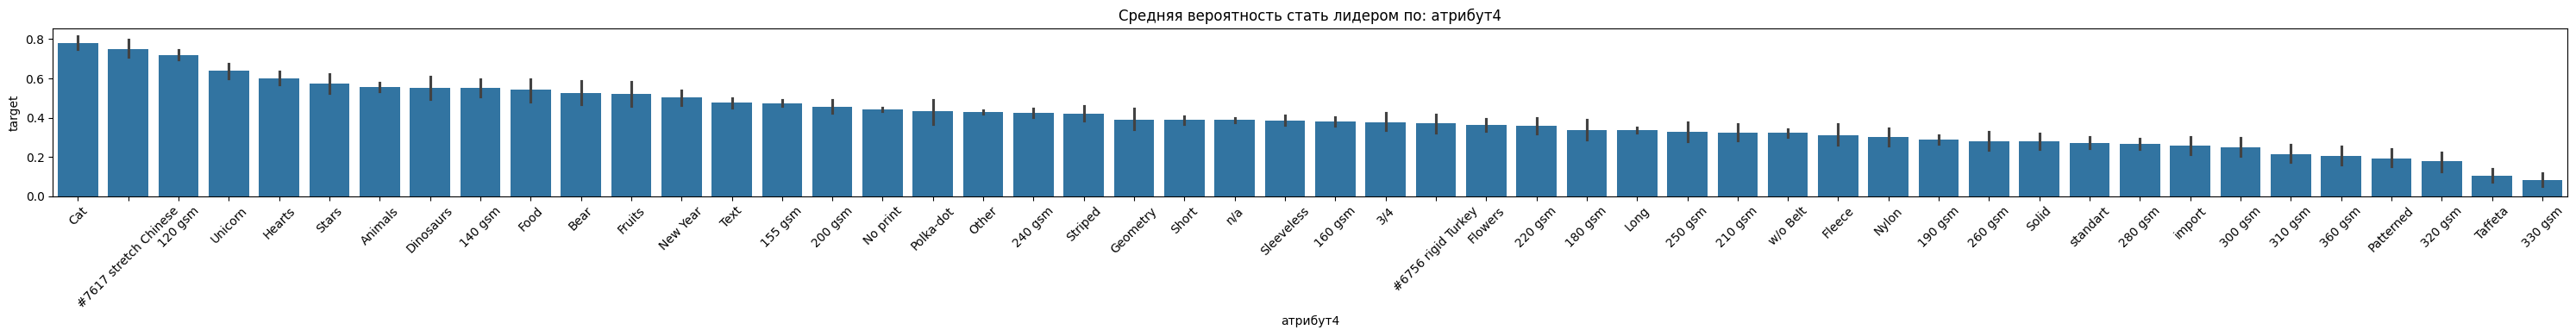

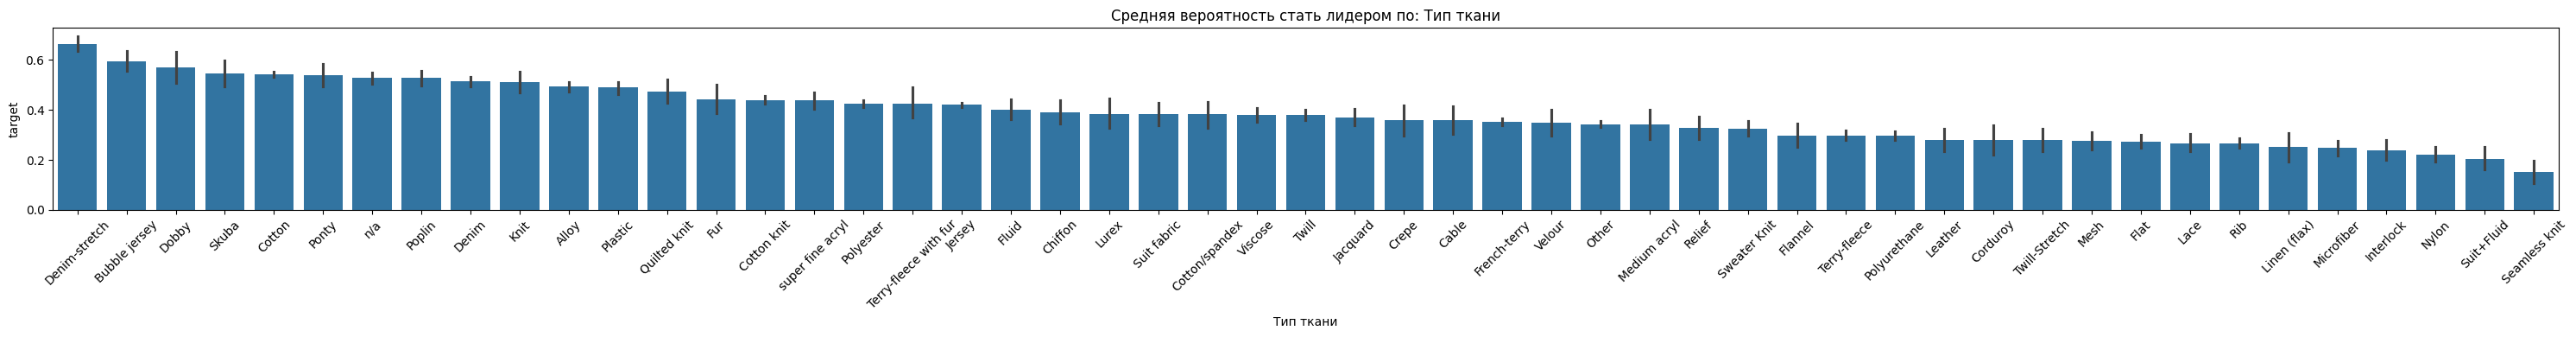

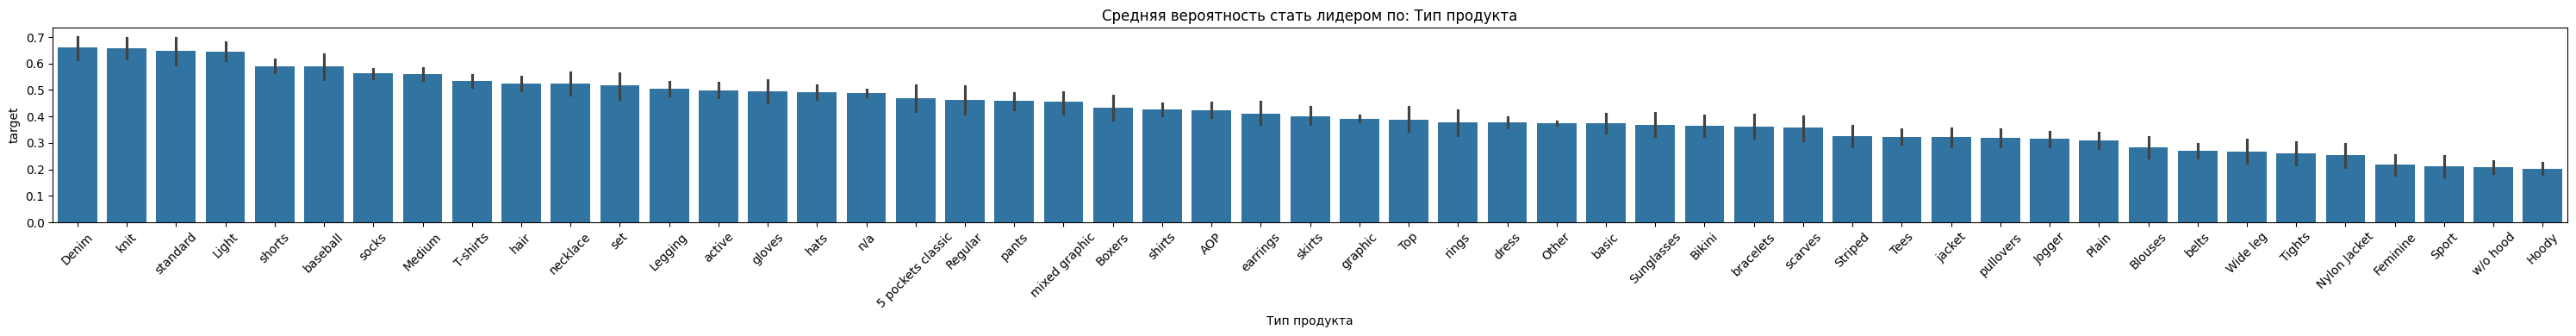

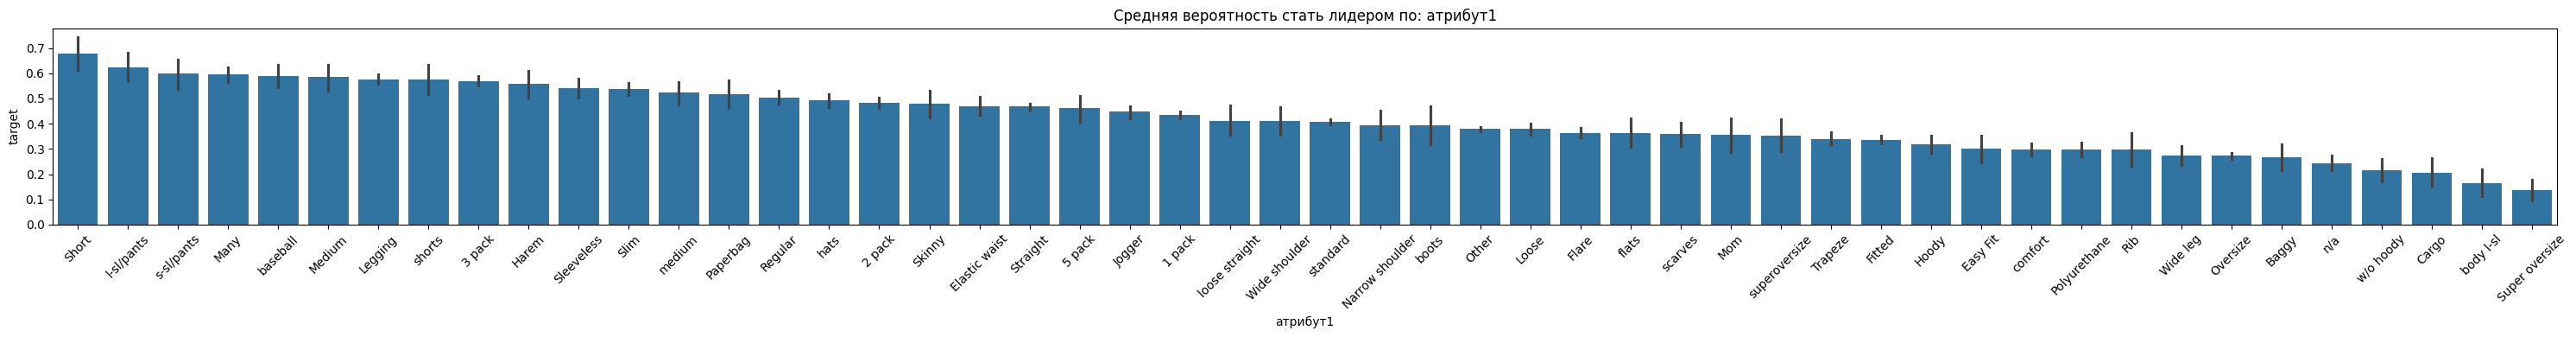

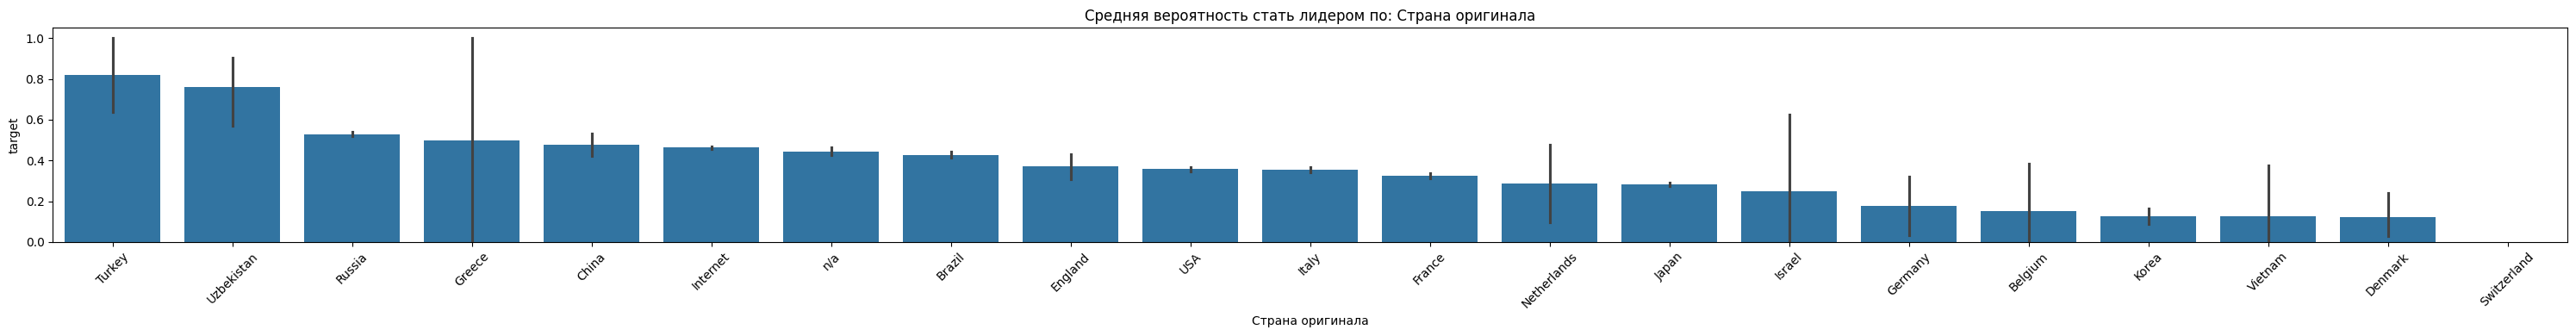

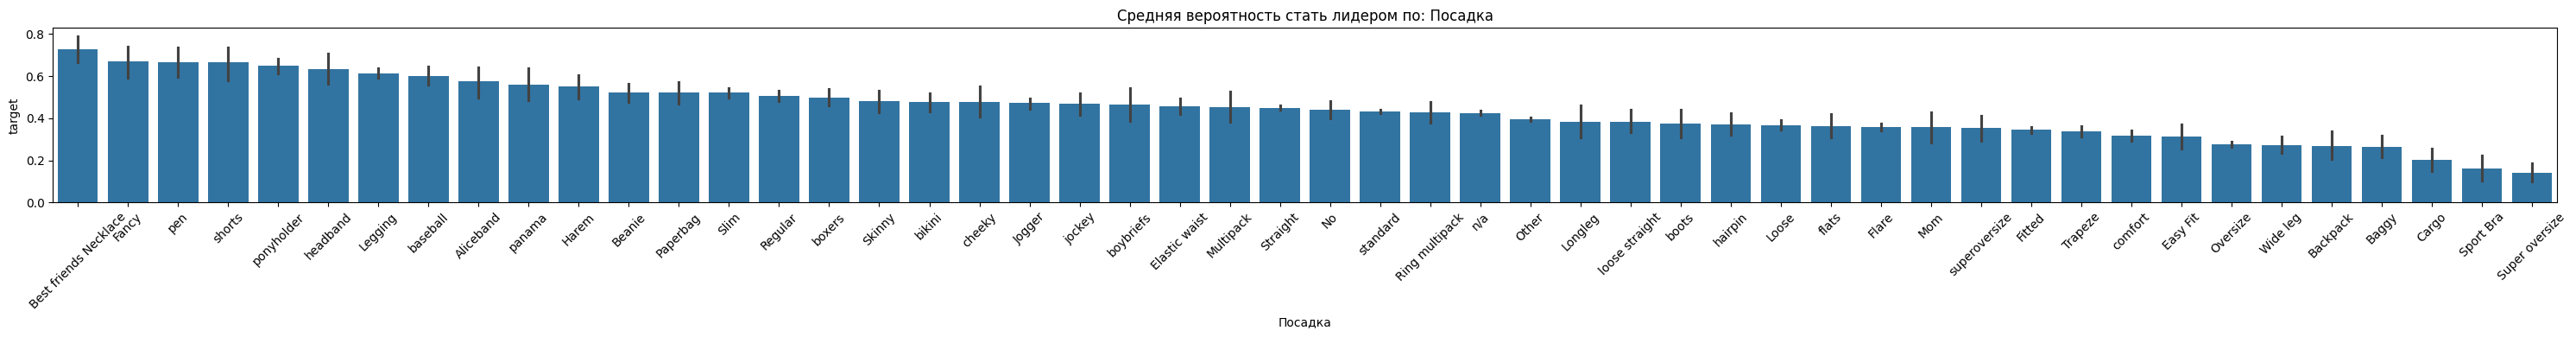

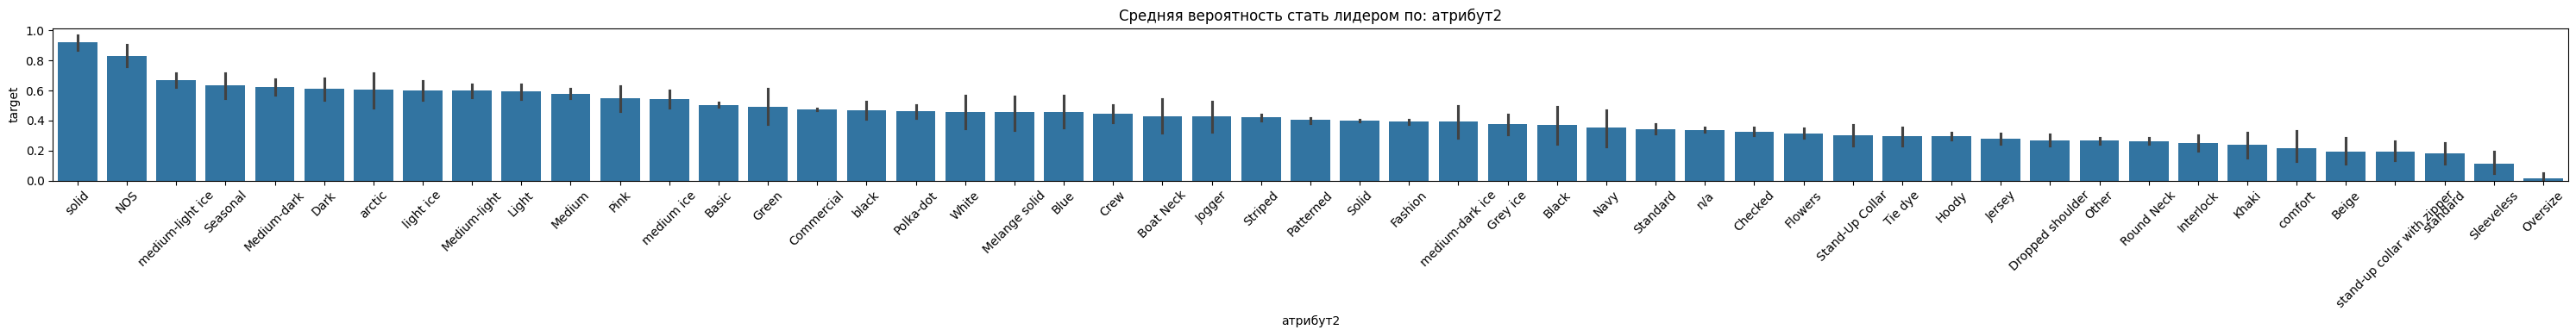

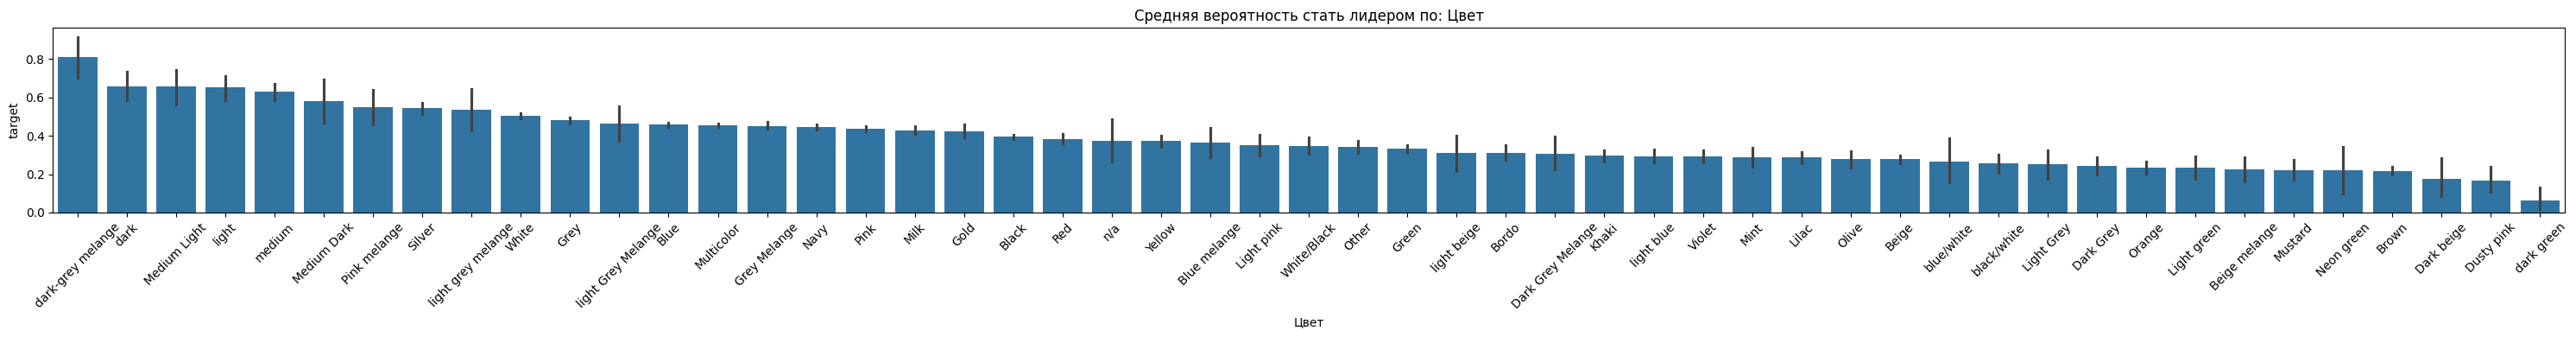

In [51]:
# Функция Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0

# Расчет Cramér's V для каждого категориального признака с таргетом
cramers_scores = {
    col: cramers_v(df[col], df['target']) for col in categorical_cols
}

# Сортировка и вывод
cramers_sorted = sorted(cramers_scores.items(), key=lambda x: x[1], reverse=True)
top_10 = pd.DataFrame(cramers_sorted[:10], columns=["Категориальный признак", "Cramér's V"])

print("Топ-10 категориальных признаков по связи с target:")
print(top_10)

# Визуализация top_10 категориальных признаков с помощью barplot

top_10_cols = top_10["Категориальный признак"].tolist()  # список имён колонок

for col in top_10_cols:
    plt.figure(figsize=(30, 4))
    sns.barplot(x=col, y='target', data=df, 
            order=df.groupby(col)['target'].mean().sort_values(ascending=False).index)
    plt.xticks(rotation=45)
    plt.title(f"Средняя вероятность стать лидером по: {col}")
    plt.tight_layout()
    plt.show()


In [39]:
X = df.drop('target',axis=1)
Y = df['target']

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [74]:
categorical_cols=['Товарная категория','Товарная группа','Целевая группа','Ассортимент','Производство обобщенное','атрибут1','атрибут2','атрибут4','Страна оригинала','Страна производства','Тип ткани','Цвет','Однотонность','Элементы дизайна','Посадка','Модность','Тип продукта','Коллекция','Атрибут цены','МЕСЯЦ PMM']
numeric_cols=['Кол-во размеров','Себестоимость','Цена розничная','IMU','Год','НЕДЕЛЯ PMM','Заказ','Глубина на модель']

Закодируем категориальные признаки

In [75]:
encoder = MixedCategoricalEncoder(threshold=5)
encoder.fit(X_train[categorical_cols], Y_train)

MixedCategoricalEncoder()

In [76]:
X_train_cat = encoder.transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

In [77]:
X_train_full = pd.concat([X_train[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

In [78]:
X_test_full.head()

,Кол-во размеров,Себестоимость,Цена розничная,IMU,Год,НЕДЕЛЯ PMM,Заказ,Глубина на модель,Товарная категория,Товарная группа,Целевая группа,атрибут1,атрибут2,атрибут4,Страна оригинала,Страна производства,Тип ткани,Цвет,Однотонность,Элементы дизайна,Посадка,Модность,Тип продукта,Коллекция,МЕСЯЦ PMM,Ассортимент_Основной ассортимент,Производство обобщенное_own,Производство обобщенное_own+import,Атрибут цены_Low,Атрибут цены_Medium,Атрибут цены_n/a
0,4,74,249,0.673092,2017,52,10000,4.386726,0.465578,0.424003,0.416678,0.469304,0.400258,0.481804,0.463748,0.392741,0.420547,0.475765,0.401952,0.509350,0.450986,0.514599,0.688259,0.408072,0.376431,1,0,0,1,0,0
1,1,92,399,0.723308,2024,12,6000,10.638298,0.478191,0.451929,0.379477,0.300000,0.471638,0.386106,0.463748,0.391106,0.484432,0.423604,0.401952,0.380512,0.300000,0.408439,0.376147,0.452604,0.383567,0,0,0,0,1,0
2,3,28,129,0.739535,2019,2,8000,4.875076,0.576207,0.546183,0.391198,0.431829,0.471638,0.519608,0.463748,0.521295,0.541045,0.396604,0.447301,0.509350,0.420137,0.408439,0.559890,0.408072,0.332495,0,0,0,1,0,0
3,3,130,399,0.665105,2018,50,10000,6.245742,0.295075,0.424003,0.451345,0.469304,0.400258,0.377038,0.525313,0.392741,0.420547,0.454359,0.401952,0.509350,0.450986,0.408439,0.388491,0.408072,0.376431,1,0,0,0,0,0
4,10,1022,2999,0.620694,2024,27,3000,2.048092,0.508070,0.454020,0.379477,0.469304,0.370130,0.090909,0.281392,0.521295,0.271930,0.475765,0.401952,0.380512,0.450986,0.408439,0.000000,0.404944,0.450322,1,1,0,1,0,0


Логистическая Регрессия

In [79]:
pipe_log = Pipeline([('Scaler',StandardScaler()),('LR',LogisticRegression(class_weight='balanced'))])
pipe_log.fit(X_train_full,Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('LR', LogisticRegression(class_weight='balanced'))])

In [80]:
y_pred_log = pipe_log.predict(X_test_full)
y_proba_log = pipe_log.predict_proba(X_test_full)[:, 1]
print("LogisticRegression_STScaler :\n", classification_report(Y_test, y_pred_log, digits=3))

LogisticRegression_STScaler :
               precision    recall  f1-score   support

         0.0      0.766     0.679     0.720      8791
         1.0      0.608     0.707     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



In [81]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_log).ravel()

print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')

True Negative: 5965
False Positive: 2826
False Negative: 1821
True Positive: 4392


Линейный SVM

In [84]:
from sklearn.svm import LinearSVC
pipe_svm = Pipeline([('Scaler',StandardScaler()),('LR',LinearSVC(class_weight='balanced'))])
pipe_svm.fit(X_train_full,Y_train)


y_pred_svm = pipe_svm.predict(X_test_full)
y_scores_svm= pipe_svm.decision_function(X_test_full)    #LinearSVC не поддерживает метод .predict_proba(). Используем decision_function - возвращает не вероятности, а оценку расстояния до границы

print("LinearSVC:\n", classification_report(Y_test, y_pred_svm, digits=3))

LinearSVC:
               precision    recall  f1-score   support

         0.0      0.767     0.677     0.719      8791
         1.0      0.608     0.708     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



In [85]:
pipe_svm.get_params()

{'memory': None,
 'steps': [('Scaler', StandardScaler()),
  ('LR', LinearSVC(class_weight='balanced'))],
 'transform_input': None,
 'verbose': False,
 'Scaler': StandardScaler(),
 'LR': LinearSVC(class_weight='balanced'),
 'Scaler__copy': True,
 'Scaler__with_mean': True,
 'Scaler__with_std': True,
 'LR__C': 1.0,
 'LR__class_weight': 'balanced',
 'LR__dual': 'auto',
 'LR__fit_intercept': True,
 'LR__intercept_scaling': 1,
 'LR__loss': 'squared_hinge',
 'LR__max_iter': 1000,
 'LR__multi_class': 'ovr',
 'LR__penalty': 'l2',
 'LR__random_state': None,
 'LR__tol': 0.0001,
 'LR__verbose': 0}

In [86]:
from sklearn.model_selection import GridSearchCV
params = {
    'LR__C':[1.0,1.1,1.2,1.3],
    'LR__loss': ['hinge','squared_hinge'],
    'LR__penalty':['l1','l2']
}

In [87]:
search = GridSearchCV(pipe_svm, params, cv=2)
search.fit(X_train_full,Y_train)
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.69426):
{'LR__C': 1.0, 'LR__loss': 'squared_hinge', 'LR__penalty': 'l1'}


In [89]:
pipe_svm_gp = Pipeline([('Scaler',StandardScaler()),('LR',LinearSVC(class_weight='balanced', C=1.0, loss='squared_hinge',penalty= 'l1'))])
pipe_svm_gp.fit(X_train_full,Y_train)

y_pred_svm_gp = pipe_svm_gp.predict(X_test_full)
y_scores_svm_gp= pipe_svm_gp.decision_function(X_test_full)    #LinearSVC не поддерживает метод .predict_proba(). Используем decision_function - возвращает не вероятности, а оценку расстояния до границы
print("LinearSVC c подбором параметров:\n", classification_report(Y_test, y_pred_svm_gp, digits=3))

LinearSVC c подбором параметров:
               precision    recall  f1-score   support

         0.0      0.767     0.677     0.719      8791
         1.0      0.608     0.708     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



Нелинейный SVM

In [ ]:
from sklearn.svm import SVC
pipe_svc = Pipeline([('Scaler',StandardScaler()),('LR',SVC(class_weight='balanced', probability=True))])
pipe_svc.fit(X_train_full,Y_train)

y_pred_svc = pipe_svc.predict(X_test_full)
y_proba_svc = pipe_svc.predict_proba(X_test_full)[:, 1]
print("SVC:\n", classification_report(Y_test, y_pred_svc, digits=3))

SVC:
               precision    recall  f1-score   support

         0.0      0.810     0.738     0.773      8783
         1.0      0.672     0.756     0.711      6221

    accuracy                          0.746     15004
   macro avg      0.741     0.747     0.742     15004
weighted avg      0.753     0.746     0.747     15004



In [90]:
from sklearn.neighbors import KNeighborsClassifier
pipe_KNC = Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsClassifier(n_neighbors=5))])
pipe_KNC.fit(X_train_full,Y_train)

y_pred_KNC = pipe_KNC.predict(X_test_full)
y_proba_KNC= pipe_KNC.predict_proba(X_test_full)[:, 1]
print("KNC:\n", classification_report(Y_test, y_pred_KNC, digits=3))

KNC:
               precision    recall  f1-score   support

         0.0      0.789     0.804     0.796      8791
         1.0      0.715     0.695     0.705      6213

    accuracy                          0.759     15004
   macro avg      0.752     0.750     0.751     15004
weighted avg      0.758     0.759     0.758     15004



In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

Ансамблевые модели

Случайный лес/Random Forest

In [92]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, Y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf= rf.predict_proba(X_test_scaled)[:, 1]
print("Random Forest:\n", classification_report(Y_test, y_pred_rf, digits=3))

Random Forest:
               precision    recall  f1-score   support

         0.0      0.822     0.885     0.852      8791
         1.0      0.817     0.729     0.771      6213

    accuracy                          0.820     15004
   macro avg      0.820     0.807     0.812     15004
weighted avg      0.820     0.820     0.819     15004



Градиентный бустинг/Gradient Boosting

In [93]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb.fit(X_train_scaled, Y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb= gb.predict_proba(X_test_scaled)[:, 1]
print("Gradient Boosting:\n", classification_report(Y_test, y_pred_gb, digits=3))

Gradient Boosting:
               precision    recall  f1-score   support

         0.0      0.753     0.814     0.782      8791
         1.0      0.703     0.623     0.660      6213

    accuracy                          0.735     15004
   macro avg      0.728     0.718     0.721     15004
weighted avg      0.732     0.735     0.732     15004



Бэггинг + логистическая регрессия/Bagging + Logistic Regression

In [94]:
bag = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_estimators=10,
    random_state=42
)
bag.fit(X_train_scaled, Y_train)

y_pred_bag = bag.predict(X_test_scaled)
y_proba_bag= bag.predict_proba(X_test_scaled)[:, 1]
print("Bagging + LogisticRegression:\n", classification_report(Y_test, y_pred_bag, digits=3))

Bagging + LogisticRegression:
               precision    recall  f1-score   support

         0.0      0.766     0.678     0.719      8791
         1.0      0.608     0.707     0.654      6213

    accuracy                          0.690     15004
   macro avg      0.687     0.693     0.687     15004
weighted avg      0.701     0.690     0.692     15004



Extra Trees Classifier

In [95]:
et = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
et.fit(X_train_scaled, Y_train)

y_pred_et = et.predict(X_test_scaled)
y_proba_et= et.predict_proba(X_test_scaled)[:, 1]
print("ExtraTreesClassifier:\n", classification_report(Y_test, y_pred_et, digits=3))

ExtraTreesClassifier:
               precision    recall  f1-score   support

         0.0      0.831     0.873     0.852      8791
         1.0      0.807     0.749     0.777      6213

    accuracy                          0.822     15004
   macro avg      0.819     0.811     0.814     15004
weighted avg      0.821     0.822     0.821     15004



Ансамбли

VotingClassifier — голосование по меткам или вероятностям

In [96]:
# Ансамбль через голосование

voting = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ],
    voting='soft' # используем вероятности
)
# Обучение
voting.fit(X_train_scaled, Y_train)

# Предсказания
y_pred_voting_rf_et_lr = voting.predict(X_test_scaled)
y_proba_voting_rf_et_lr = voting.predict_proba(X_test_scaled)[:, 1]

# Оценка качества

print("VotingClassifier (RF + ET + LR):\n", classification_report(Y_test, y_pred_voting_rf_et_lr, digits=3))

VotingClassifier (RF + ET + LR):
               precision    recall  f1-score   support

         0.0      0.832     0.857     0.844      8791
         1.0      0.789     0.755     0.772      6213

    accuracy                          0.815     15004
   macro avg      0.810     0.806     0.808     15004
weighted avg      0.814     0.815     0.814     15004



StackingClassifier

In [97]:
# Мета-модель (level-1)
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Стекинг
stacking = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ],
    final_estimator=meta_model,
    passthrough=True,  # передаём исходные признаки в мета-модель
    cv=5,              # кросс-валидация для out-of-fold предсказаний
    n_jobs=1
)

# Обучение
stacking.fit(X_train_scaled, Y_train)

# Предсказания и оценка
y_pred_stack = stacking.predict(X_test_scaled)
y_proba_stack  = stacking.predict_proba(X_test_scaled)[:, 1]

print("StackingClassifier (RF + ET + LR):\n", classification_report(Y_test, y_pred_stack, digits=3))

StackingClassifier (RF + ET + LR):
               precision    recall  f1-score   support

         0.0      0.860     0.836     0.848      8791
         1.0      0.777     0.807     0.792      6213

    accuracy                          0.824     15004
   macro avg      0.818     0.822     0.820     15004
weighted avg      0.825     0.824     0.825     15004



In [98]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
history = model.fit(
    X_train_scaled, Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6916 - loss: 0.5806 - val_accuracy: 0.7179 - val_loss: 0.5500
Epoch 2/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7204 - loss: 0.5475 - val_accuracy: 0.7228 - val_loss: 0.5411
Epoch 3/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7249 - loss: 0.5426 - val_accuracy: 0.7275 - val_loss: 0.5402
Epoch 4/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7289 - loss: 0.5379 - val_accuracy: 0.7343 - val_loss: 0.5325
Epoch 5/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7293 - loss: 0.5304 - val_accuracy: 0.7383 - val_loss: 0.5292
Epoch 6/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7390 - loss: 0.5240 - val_accuracy: 0.7357 - val_loss: 0.5257
Epoch 7/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7381 - loss: 0.5247 - val_accuracy: 0.7373 - val_loss: 0.5252
Epoch 8/50
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7392 - loss: 0.5221 - 

In [102]:
y_proba_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_proba_nn >= 0.36).astype(int)
print("Нейронная сеть:\n", classification_report(Y_test, y_pred_nn, digits=3))

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
Нейронная сеть:
               precision    recall  f1-score   support

         0.0      0.840     0.671     0.746      8791
         1.0      0.637     0.819     0.717      6213

    accuracy                          0.732     15004
   macro avg      0.738     0.745     0.731     15004
weighted avg      0.756     0.732     0.734     15004



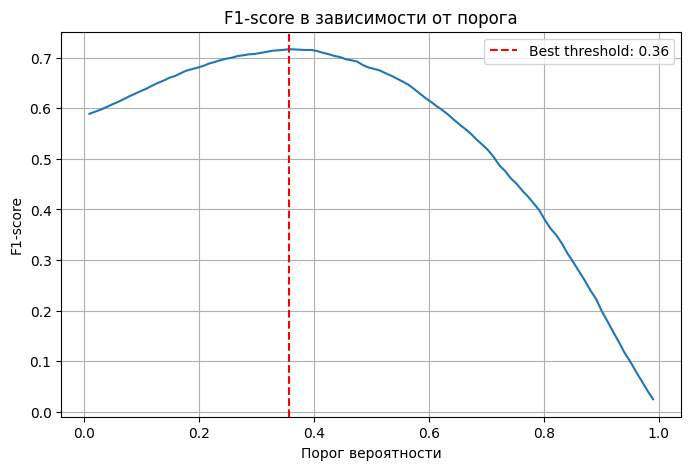

🔎 Лучший порог: 0.36
🎯 F1-score при нём: 0.717


In [101]:
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [f1_score(Y_test, (y_proba_nn >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# График F1-score по порогам
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.xlabel("Порог вероятности")
plt.ylabel("F1-score")
plt.title("F1-score в зависимости от порога")
plt.grid(True)

# Лучший порог
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
plt.axvline(best_thresh, color='red', linestyle='--', label=f"Best threshold: {best_thresh:.2f}")
plt.legend()
plt.show()



print(f"🔎 Лучший порог: {best_thresh:.2f}")
print(f"🎯 F1-score при нём: {best_f1:.3f}")

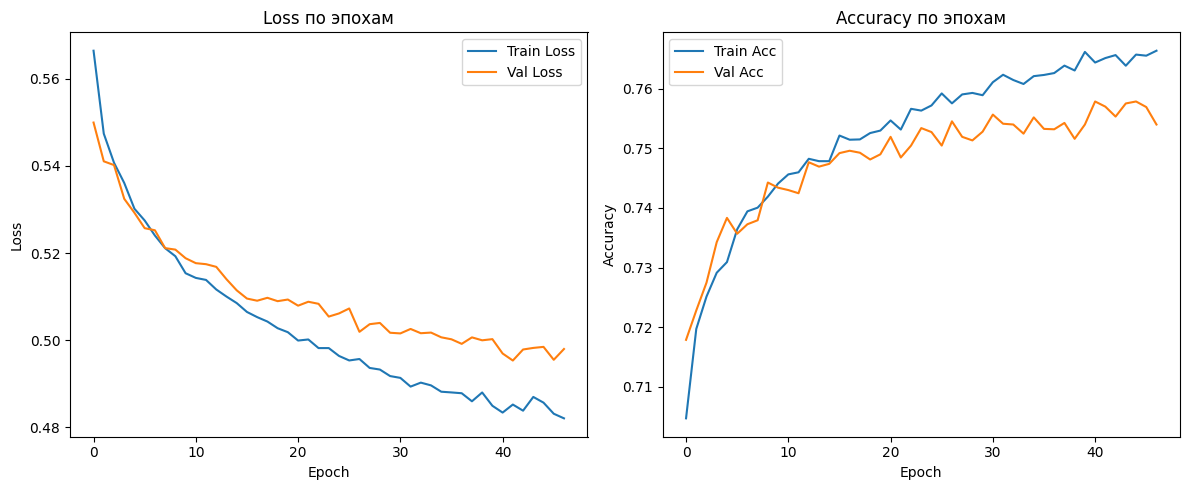

In [103]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss по эпохам")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy по эпохам")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

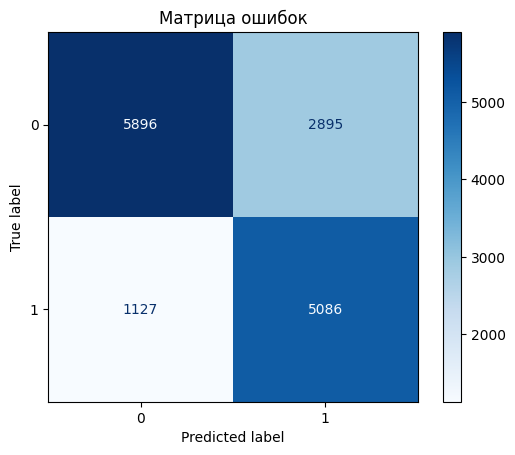

In [104]:
cm = confusion_matrix(Y_test, y_pred_nn)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

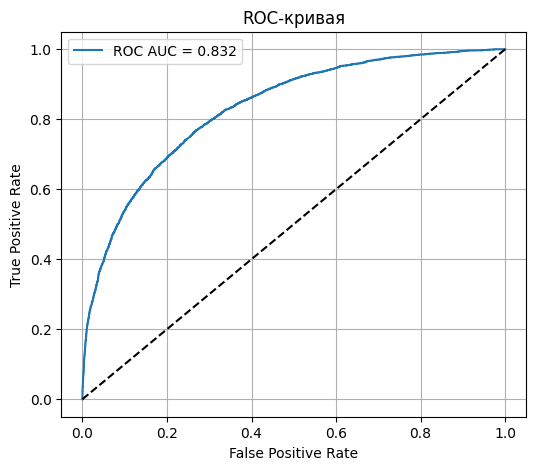

In [105]:
fpr, tpr, _ = roc_curve(Y_test, y_proba_nn)
auc = roc_auc_score(Y_test, y_proba_nn)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid()
plt.show()

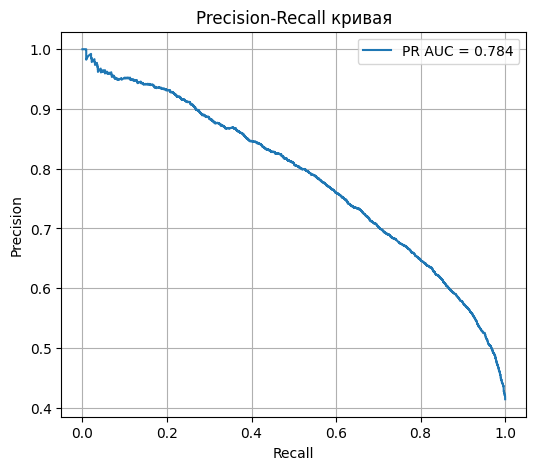

In [106]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, pr_thresholds = precision_recall_curve(Y_test, y_proba_nn)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривая")
plt.legend()
plt.grid(True)
plt.show()

Сделаем таблицу сравнения

In [108]:
# Итоговая таблица сравнения
comparison = pd.DataFrame([
    {
        "Model": "LogisticRegression_STScaler",
        "F1-score": round(f1_score(Y_test, y_pred_log), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_pred_log ), 3)
    },
    {
        "Model": "LinearSVC",
        "F1-score": round(f1_score(Y_test, y_pred_svm), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_scores_svm ), 3)
    },
    {
        "Model": "LinearSVC c подбором параметров",
        "F1-score": round(f1_score(Y_test, y_pred_svm_gp), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_scores_svm_gp), 3)
    },
    #{
    #  "Model": "SVC",
    #   "F1-score": round(f1_score(Y_test, y_pred_svc), 3),
    #   "ROC AUC": round(roc_auc_score(Y_test, y_proba_svc), 3)
    #},
    {
        "Model": "Random Forest",
        "F1-score": round(f1_score(Y_test, y_pred_rf), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_rf), 3)
    },
    {
        "Model": "Gradient Boosting",
        "F1-score": round(f1_score(Y_test, y_pred_gb), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_gb), 3)
    },
    {
        "Model": "Bagging + LogisticRegression",
        "F1-score": round(f1_score(Y_test, y_pred_bag), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_bag), 3)
    },
    {
        "Model": "ExtraTreesClassifier",
        "F1-score": round(f1_score(Y_test, y_pred_et), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_et), 3)
    },
    {
        "Model": "VotingClassifier (RF + ET + LR)",
        "F1-score": round(f1_score(Y_test, y_pred_voting_rf_et_lr), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_voting_rf_et_lr), 3)
    },
    {
        "Model": "StackingClassifier (RF + ET + LR)",
        "F1-score": round(f1_score(Y_test, y_pred_stack), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_stack), 3)
    },
    {
        "Model": "Neural Network",
        "F1-score": round(f1_score(Y_test, y_pred_nn), 3),
        "ROC AUC": round(roc_auc_score(Y_test, y_proba_nn), 3)
    }
])
print (comparison)


                               Model  F1-score  ROC AUC
0        LogisticRegression_STScaler     0.654    0.693
1                          LinearSVC     0.654    0.763
2    LinearSVC c подбором параметров     0.654    0.763
3                      Random Forest     0.771    0.895
4                  Gradient Boosting     0.660    0.800
5       Bagging + LogisticRegression     0.654    0.763
6               ExtraTreesClassifier     0.777    0.898
7    VotingClassifier (RF + ET + LR)     0.772    0.890
8  StackingClassifier (RF + ET + LR)     0.792    0.902
9                     Neural Network     0.717    0.832


Постоим матрицу предсказаний для моделей с нивысшим F1-score

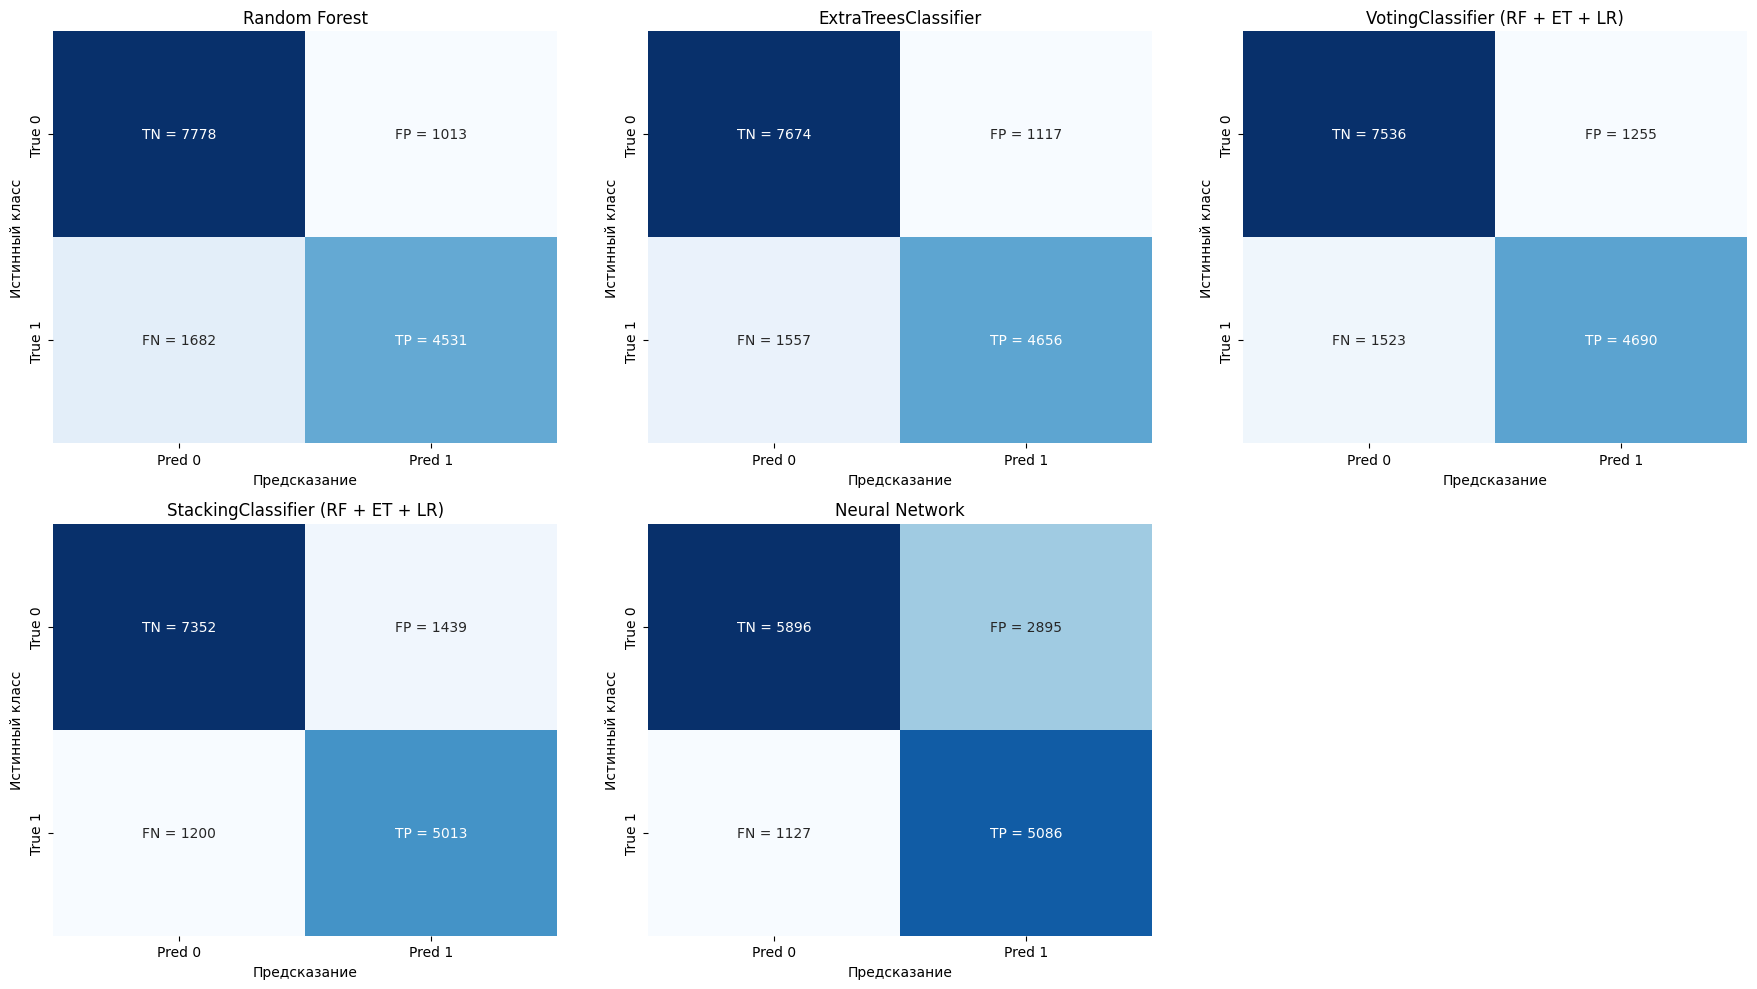

In [109]:
# Словарь моделей и их предсказаний
models_preds = {
    "Random Forest": y_pred_rf,
    "ExtraTreesClassifier": y_pred_et,
    "VotingClassifier (RF + ET + LR)": y_pred_voting_rf_et_lr,
    "StackingClassifier (RF + ET + LR)": y_pred_stack,
    "Neural Network": y_pred_nn,
}

# Построение подграфиков
n = len(models_preds)
cols = 3
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(models_preds.items()):
    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    labels = np.array([
        [f"TN = {tn}", f"FP = {fp}"],
        [f"FN = {fn}", f"TP = {tp}"]
    ])

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                ax=axes[idx])
    
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("Предсказание")
    axes[idx].set_ylabel("Истинный класс")

# Удалить лишние пустые подграфики
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.subplots_adjust(wspace=50, hspace=50)

plt.tight_layout()
plt.show()

Построим для этих моделей PR-кривые, чтобы визуализировать, какая модель действительно лучше определяет лидеров

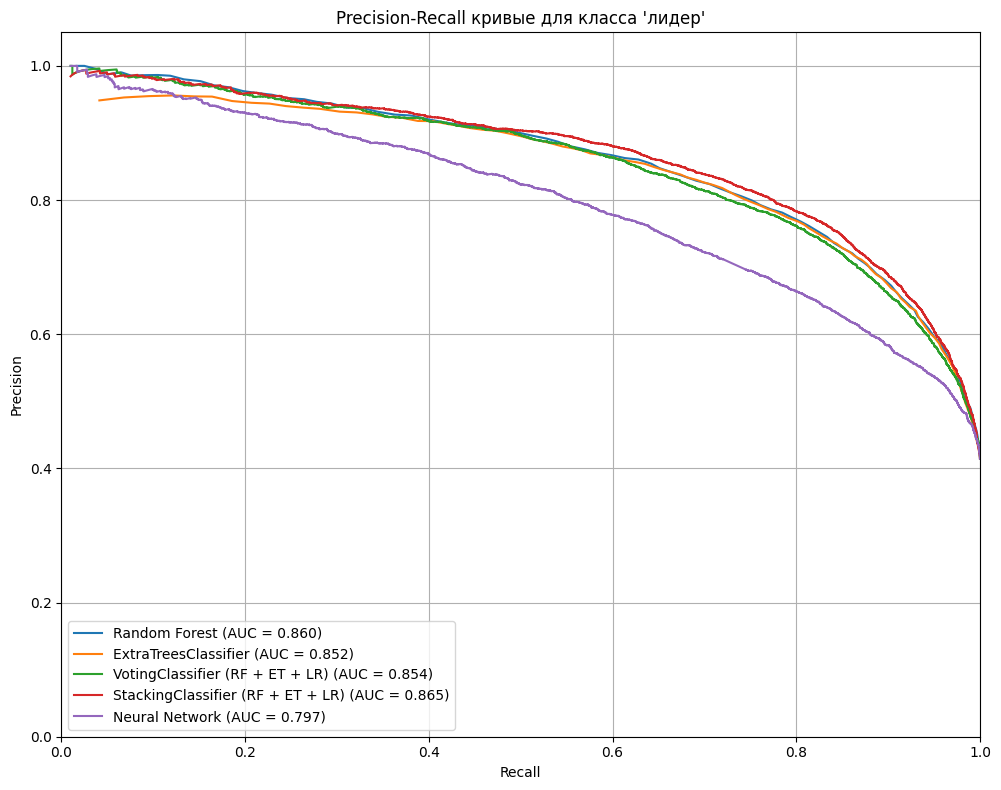

In [98]:
# Получение точности и полноты для всех моделей
prec_rf, rec_rf, _ = precision_recall_curve(Y_test, y_proba_rf)
prec_et, rec_et, _ = precision_recall_curve(Y_test, y_proba_et)
prec_voting, rec_voting, _ = precision_recall_curve(Y_test, y_proba_voting_rf_et_lr)
prec_stack, rec_stack, _ = precision_recall_curve(Y_test, y_proba_stack)
prec_nn, rec_nn, _ = precision_recall_curve(Y_test, y_proba_nn)

# Минимальный порог по recall
min_recall_threshold = 0.01

# Маски
mask_rf = rec_rf > min_recall_threshold
mask_et = rec_et > min_recall_threshold
mask_voting = rec_voting > min_recall_threshold
mask_stack = rec_stack > min_recall_threshold
mask_nn = rec_nn > min_recall_threshold

# Построение PR-кривых
plt.figure(figsize=(10, 8))
plt.plot(rec_rf[mask_rf], prec_rf[mask_rf], label=f"Random Forest (AUC = {auc(rec_rf, prec_rf):.3f})")
plt.plot(rec_et[mask_et], prec_et[mask_et], label=f"ExtraTreesClassifier (AUC = {auc(rec_et, prec_et):.3f})")
plt.plot(rec_voting[mask_voting], prec_voting[mask_voting], label=f"VotingClassifier (RF + ET + LR) (AUC = {auc(rec_voting, prec_voting):.3f})")
plt.plot(rec_stack[mask_stack], prec_stack[mask_stack], label=f"StackingClassifier (RF + ET + LR) (AUC = {auc(rec_stack, prec_stack):.3f})")
plt.plot(rec_nn[mask_nn], prec_nn[mask_nn], label=f"Neural Network (AUC = {auc(rec_nn, prec_nn):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривые для класса 'лидер'")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.show()